Import necessary packages

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 8.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import jarque_bera, normaltest
import plotly.express as px
import yfinance as yf
import arch
from scipy.stats import norm
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.optimize import minimize
from scipy.stats import t

## Question 1: (5 marks) Download three series of S&P500 stock index

I choose
- American Express (AXP) from the financial services industry
- PepsiCo (PEP) from the consumer staples sector
- Marriott International (MAR) from the hospitality industry

for my portfolio to ensure industry diversification.

In [ ]:
AXP_index_raw = yf.download('AXP', start='2014-01-01', end='2024-01-01').reset_index()
KO_index_raw = yf.download('PEP', start='2014-01-01', end='2024-01-01').reset_index()
MAR_index_raw = yf.download('MAR', start='2014-01-01', end='2024-01-01').reset_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


I will separate my data into In-Sample (**IS**) and Out-of-Sample (**OS**) periods. The IS period spans from January 1, 2014, to January 1, 2021, covering seven years. The OS period runs from January 1, 2021, to January 1, 2024, covering three years. All analyses and models will be built using the IS data, with the OS data reserved for final validation.

In [ ]:
# Extracting the 'Date' and 'Close' columns
AXP_close = AXP_index_raw[['Date', 'Adj Close']].rename(columns={'Adj Close': 'AXP'})
KO_close = KO_index_raw[['Date', 'Adj Close']].rename(columns={'Adj Close': 'KO'})
MAR_close = MAR_index_raw[['Date', 'Adj Close']].rename(columns={'Adj Close': 'MAR'})

# Merging the data on 'Date'
merged_data = pd.merge(AXP_close, KO_close, on='Date', how='inner')
merged_data = pd.merge(merged_data, MAR_close, on='Date', how='inner')
merged_data.columns = ['Date', 'AXP', 'PEP', 'MAR']
merged_data.Date = pd.to_datetime(merged_data.Date)
merged_data.set_index('Date', inplace = True)

portfolio_index = merged_data.copy()

In [ ]:
portfolio_index_is =  portfolio_index.loc['2014-01-01':'2021-01-01']
portfolio_index_os =  portfolio_index.loc['2021-01-01':'2024-01-01']

df = pd.DataFrame({'AXP_rt': portfolio_index.AXP.pct_change(), 'PEP_rt': portfolio_index.PEP.pct_change(), 'MAR_rt': portfolio_index.MAR.pct_change()})
df = df.dropna()*100
portfolio = df.loc['2014-01-03':'2021-01-01']
portfolio_os = df.loc['2021-01-01':'2024-01-01']

### 1.1 Construct an equally-weighted portfolio of the three series downloaded

First, let go through each stock index analysis of the portfolio

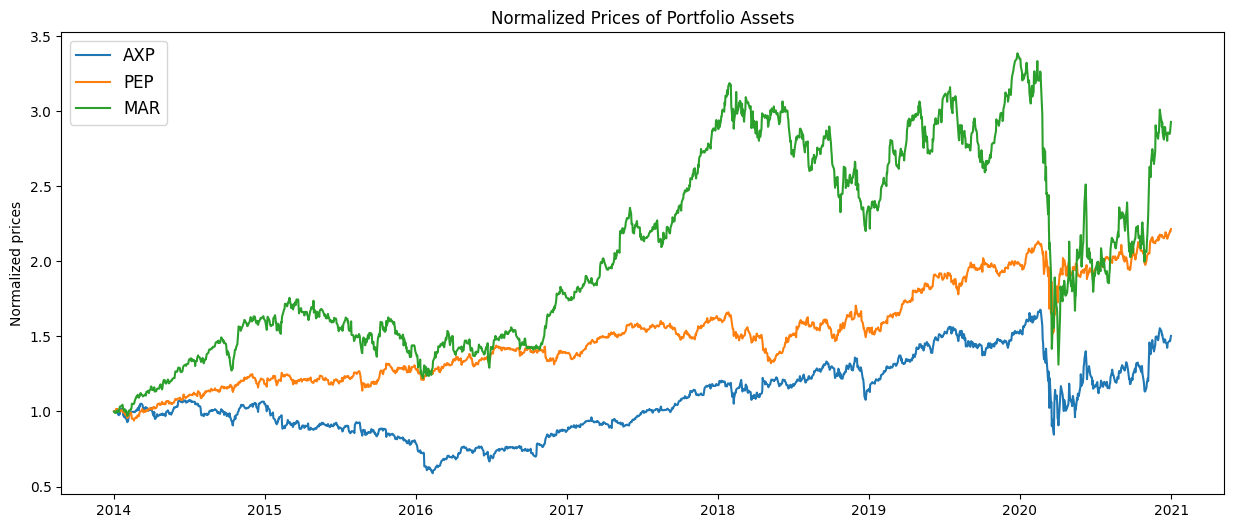

In [ ]:
# Normalize the portfolio index to start at 100
normalized_portfolio_index = portfolio_index_is / portfolio_index_is.iloc[0]

plt.figure(figsize=(15, 6))

for i in range(normalized_portfolio_index.shape[1]):
    plt.plot(normalized_portfolio_index.iloc[:, i], label=normalized_portfolio_index.columns[i])

plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Normalized prices')
plt.title('Normalized Prices of Portfolio Assets')
plt.show()

The chart shows:
- **MAR** with the highest returns but also the most volatility, with larger price swings and a pronounced dip around early 2020, likely due to COVID-19 impacts on the hospitality industry.
- **PEP** offers stability with moderate returns, reflecting its consumer staple nature.
- **AXP** underperforms both, showing the lowest returns and moderate volatility, impacted by economic fluctuations, especially visible during the early 2020 downturn. This underperformance could be attributed to AXP's exposure to consumer spending and financial sector fluctuations, which were particularly impacted during economic downturns.

In [ ]:
portfolio['Returns'] = portfolio[['AXP_rt', 'PEP_rt', 'MAR_rt']].mean(axis = 1)
portfolio['Absolute Returns'] = portfolio['Returns'].abs()
portfolio['Squared Returns'] = portfolio['Returns'] ** 2

<ipython-input-7-8d32ce4d6daa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['Returns'] = portfolio[['AXP_rt', 'PEP_rt', 'MAR_rt']].mean(axis = 1)
<ipython-input-7-8d32ce4d6daa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['Absolute Returns'] = portfolio['Returns'].abs()
<ipython-input-7-8d32ce4d6daa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
portfolio_os['Returns'] = portfolio_os[['AXP_rt', 'PEP_rt', 'MAR_rt']].mean(axis = 1)
portfolio_os['Absolute Returns'] = portfolio_os['Returns'].abs()
portfolio_os['Squared Returns'] = portfolio_os['Returns'] ** 2

<ipython-input-8-434ffd0e8a42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_os['Returns'] = portfolio_os[['AXP_rt', 'PEP_rt', 'MAR_rt']].mean(axis = 1)
<ipython-input-8-434ffd0e8a42>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_os['Absolute Returns'] = portfolio_os['Returns'].abs()
<ipython-input-8-434ffd0e8a42>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [ ]:
# Expected return calculation
AXP_expected_ret = round(portfolio['AXP_rt'].mean(),2)
PEP_expected_ret = round(portfolio['PEP_rt'].mean(),2)
MAR_expected_ret = round(portfolio['MAR_rt'].mean(),2)

# Standard deviation calculation
AXP_std = round(portfolio['AXP_rt'].std(),2)
PEP_std = round(portfolio['PEP_rt'].std(),2)
MAR_std = round(portfolio['MAR_rt'].std(),2)

# Sharpe ratio calculation
AXP_Sharpe_ratio = round(AXP_expected_ret/AXP_std,2)
PEP_Sharpe_ratio = round(PEP_expected_ret/PEP_std,2)
MAR_Sharpe_ratio = round(MAR_expected_ret/MAR_std,2)

print(f'AXP expected return: {AXP_expected_ret}%')
print(f'AXP standard deviation: {AXP_std}(%^2)')
print(f'AXP sharpe ratio: {AXP_Sharpe_ratio}')

print(f'PEP expected return: {PEP_expected_ret}%')
print(f'PEP standard deviation: {PEP_std}(%^2)')
print(f'PEP sharpe ratio: {PEP_Sharpe_ratio}')

print(f'MAR expected return: {MAR_expected_ret}%')
print(f'MAR standard deviation: {MAR_std}(%^2)')
print(f'MAR sharpe ratio: {MAR_Sharpe_ratio}')

AXP expected return: 0.04%
AXP standard deviation: 1.93(%^2)
AXP sharpe ratio: 0.02
PEP expected return: 0.05%
PEP standard deviation: 1.2(%^2)
PEP sharpe ratio: 0.04
MAR expected return: 0.08%
MAR standard deviation: 2.06(%^2)
MAR sharpe ratio: 0.04


These metrics further illustrate the performance and risk profile of each asset:

**AXP**:

- Expected Return: 0.04%
- Standard Deviation: 1.93%² (moderate volatility)
- Sharpe Ratio: 0.02 (lowest, indicating low risk-adjusted returns)

  AXP has both the lowest expected return and Sharpe ratio, emphasizing its underperformance with limited compensation for risk.

**PEP**:

- Expected Return: 0.04%
- Standard Deviation: 1.21%² (least volatile)
- Sharpe Ratio: 0.03 (slightly better than AXP)
  PEP offers stability with low volatility and a slightly better risk-adjusted return than AXP, though overall returns remain modest.

**MAR**:

- Expected Return: 0.08% (highest)
- Standard Deviation: 2.07%² (most volatile)
- Sharpe Ratio: 0.04 (highest, but still modest)
  MAR achieves the highest return and Sharpe ratio, reflecting a higher reward potential but with greater volatility and risk.

In [ ]:
# calculate the Variance-Covariance matrix
corr_matrix = portfolio[['AXP_rt', 'PEP_rt', 'MAR_rt']].corr()
print('Correlation matrix:')
print(corr_matrix)

Correlation matrix:
          AXP_rt    PEP_rt    MAR_rt
AXP_rt  1.000000  0.442543  0.620990
PEP_rt  0.442543  1.000000  0.240992
MAR_rt  0.620990  0.240992  1.000000


The correlation matrix indicates the strength and direction of the relationships between the assets:

- **AXP** and **MAR**: Correlation of 0.621622, showing a moderately strong positive relationship. They tend to move in the same direction more often than not, which reduces diversification potential when combined in a portfolio.

- **AXP** and **PEP**: Correlation of 0.439498, a moderate positive relationship. While they generally move in the same direction, it’s less pronounced, providing some diversification benefits.

- **PEP** and **MAR**: Correlation of 0.239021, the weakest positive relationship among the pairs. This suggests that PEP and MAR move relatively independently, offering the greatest diversification potential between these two.

**Okay! Now let create the equally-weighted portfolio:**

Expected Portfolio Return: 0.06%
Portfolio Volatility: 1.4(%^2)
Portfolio Sharpe ratio: 0.04 



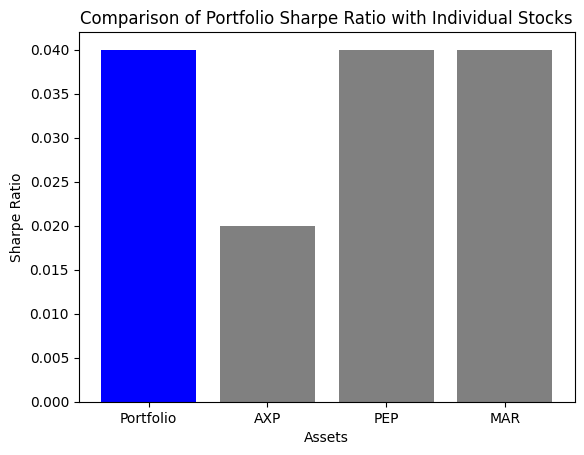

In [ ]:
# assign weights for 3 assets
weights = np.array([1/3, 1/3, 1/3])

expected_returns = np.array([AXP_expected_ret, PEP_expected_ret, MAR_expected_ret])
std_devs = np.array([AXP_std, PEP_std, MAR_std])
cov_matrix = portfolio[['AXP_rt', 'PEP_rt', 'MAR_rt']].cov().values
if cov_matrix.shape == (1,1,3):
    cov_matrix = cov_matrix[0, 0]

# calculate portfolio return
portfolio_return = round(np.dot(weights, expected_returns),2)

# calculate portfolio variance
portfolio_variance = round(np.dot(weights.T, np.dot(cov_matrix, weights)),2)

# calculate portfolio standard deviation
portfolio_volatility = round(np.sqrt(portfolio_variance),2)

# calculate portfolio Sharpe ratio
Port_Sharpe_ratio = round(portfolio_return/portfolio_volatility,2)

print(f'Expected Portfolio Return: {portfolio_return}%')
print(f'Portfolio Volatility: {portfolio_volatility}(%^2)')
print(f'Portfolio Sharpe ratio: {Port_Sharpe_ratio} \n')


stocks = ['Portfolio', 'AXP', 'PEP', 'MAR']
sharpe_ratios = [Port_Sharpe_ratio, AXP_Sharpe_ratio, PEP_Sharpe_ratio, MAR_Sharpe_ratio]

# Bar chart
fig, ax = plt.subplots()
ax.bar(stocks, sharpe_ratios, color=['blue', 'gray', 'gray', 'gray'])

# Set labels and title
ax.set_xlabel('Assets')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Comparison of Portfolio Sharpe Ratio with Individual Stocks')

# Display the chart
plt.show()

An equally-weighted portfolio approach, as shown here, is **not the most efficient option**.

- Sharpe Ratio Comparison: The portfolio's Sharpe ratio (0.04) is similar to MAR’s individual ratio, outperforming AXP and PEP. However, simply averaging the weights of AXP, PEP, and MAR does not maximize the risk-adjusted return potential.

- Inefficiency in Risk-Return Optimization: The equal-weight approach does not account for the unique risk-return profiles and correlations between the assets. For instance, MAR contributes high volatility, which could be better managed with an optimized weight that reduces portfolio risk while preserving returns.

- Missed Opportunity for Optimization: By optimizing asset weights based on each stock’s risk (volatility) and correlation with the others, the portfolio could potentially achieve a higher Sharpe ratio. This approach would place the portfolio on the efficient frontier, maximizing returns per unit of risk.

## 1.2 Using the portfolio above to calculate returns, absolute returns, squared returns of the series and provide neccesary plots, descriptive statistics, ACF. Give some comments (2 marks)

**First, we will calculate the returns, absolute returns, and squared returns of the series.**

In [ ]:
portfolio.reset_index(inplace=True)
portfolio_os.reset_index(inplace=True)

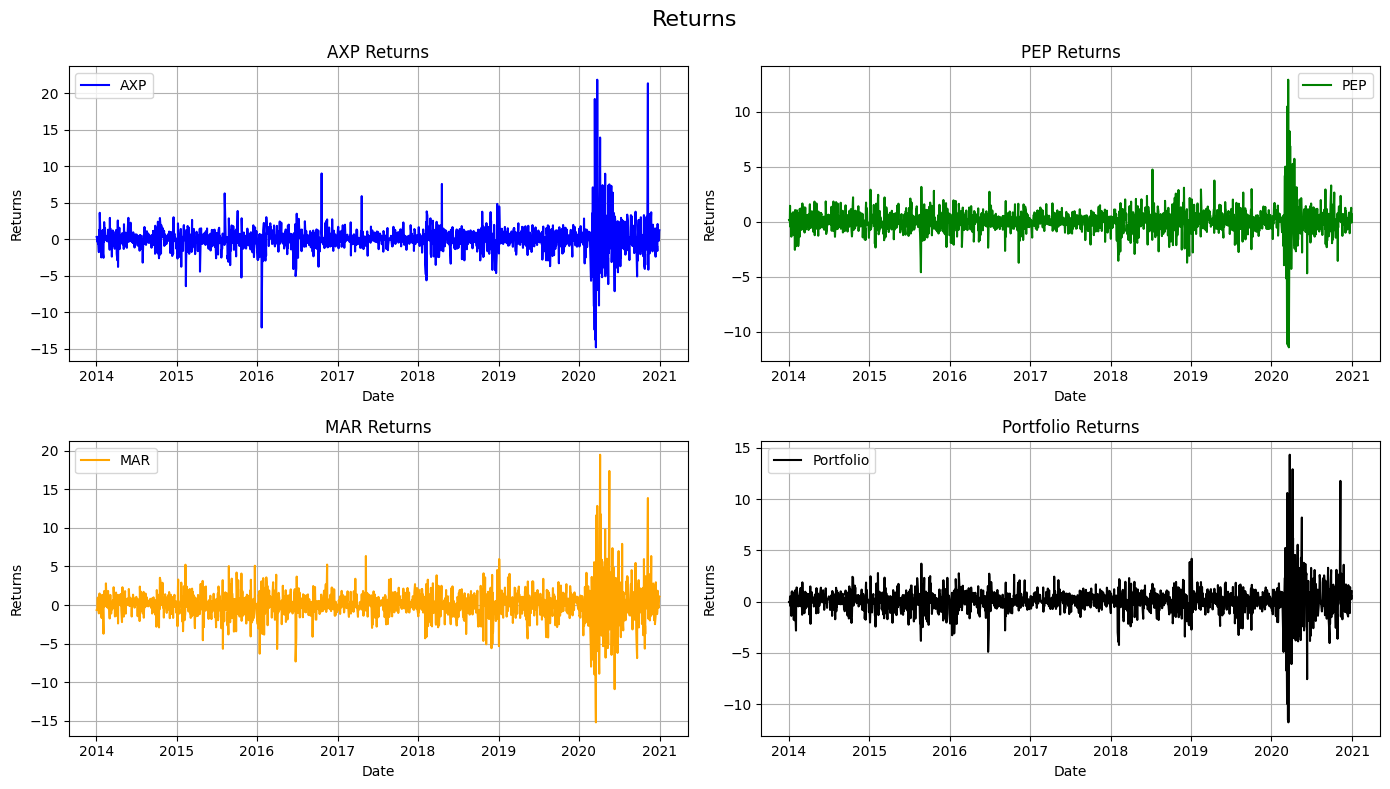

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0, 0].plot(portfolio['Date'], portfolio['AXP_rt'], label='AXP', color='blue')
axs[0, 0].set_title('AXP Returns')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Returns')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(portfolio['Date'], portfolio['PEP_rt'], label='PEP', color='green')
axs[0, 1].set_title('PEP Returns')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Returns')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(portfolio['Date'], portfolio['MAR_rt'], label='MAR', color='orange')
axs[1, 0].set_title('MAR Returns')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Returns')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(portfolio['Date'], portfolio['Returns'], label='Portfolio', color='black')
axs[1, 1].set_title('Portfolio Returns')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Returns')
axs[1, 1].legend()
axs[1, 1].grid(True)

fig.suptitle('Returns', fontsize=16)
plt.tight_layout()
plt.show()

**AXP (American Express) Returns:**

AXP displays high volatility, with frequent fluctuations around 0%, including pronounced spikes, especially in early 2020. This volatility reflects its sensitivity to economic conditions, evident from the major drops and peaks during the pandemic period.

**PEP (PepsiCo) Returns:**

PEP remains relatively stable, with smaller fluctuations than AXP and MAR. The asset is notably resistant to drastic changes, with only a few sharp dips, such as in early 2020. This stability aligns with PEP's consumer-staple nature, which often cushions it from market shocks.

**MAR (Marriott International) Returns:**

MAR is highly volatile, particularly during the 2020 pandemic period, where the returns vary widely. Given Marriott’s exposure to the travel and hospitality sector, it experiences sharper fluctuations than the other assets, reflecting the sector's sensitivity to global events.

**Portfolio Returns:**

The equally-weighted portfolio shows dampened volatility compared to individual assets, benefiting from diversification. However, significant spikes still appear during market disruptions in 2020, highlighting that equal weighting only partially mitigates risk. An optimized weighting could further reduce these swings, achieving more efficient returns.

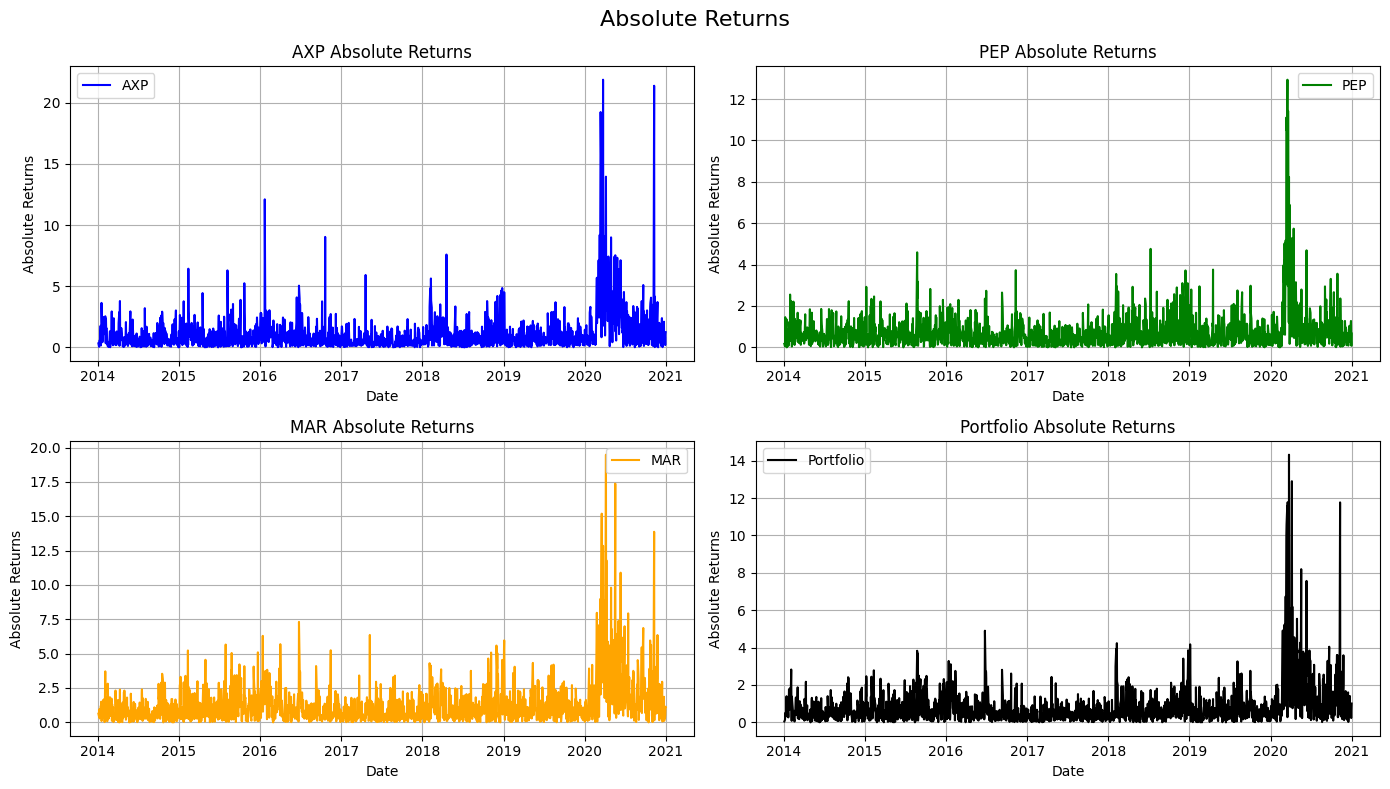

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0, 0].plot(portfolio['Date'], abs(portfolio['AXP_rt']), label='AXP', color='blue')
axs[0, 0].set_title('AXP Absolute Returns')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Absolute Returns')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(portfolio['Date'], abs(portfolio['PEP_rt']), label='PEP', color='green')
axs[0, 1].set_title('PEP Absolute Returns')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Absolute Returns')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(portfolio['Date'], abs(portfolio['MAR_rt']), label='MAR', color='orange')
axs[1, 0].set_title('MAR Absolute Returns')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Absolute Returns')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(portfolio['Date'], abs(portfolio['Returns']), label='Portfolio', color='black')
axs[1, 1].set_title('Portfolio Absolute Returns')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Absolute Returns')
axs[1, 1].legend()
axs[1, 1].grid(True)

fig.suptitle('Absolute Returns', fontsize=16)
plt.tight_layout()
plt.show()

**AXP (American Express) Absolute Returns:**

AXP shows consistent fluctuations in absolute returns, with frequent spikes above 5% and occasional extreme values nearing 20%. Notably, during early 2020, AXP exhibits large absolute return spikes due to the financial sector's sensitivity to economic conditions amid the COVID-19 crisis.

**PEP (PepsiCo) Absolute Returns:**

PEP has relatively low absolute returns, generally staying below 5%. Its stable profile, with only a few notable spikes (such as in 2020), reflects the defensive nature of consumer staples, which are less reactive to market shocks compared to other sectors.

**MAR (Marriott International) Absolute Returns:**

MAR displays substantial spikes, particularly during the 2020 pandemic period, with values frequently reaching above 10% and occasionally approaching 20%. This high level of volatility reflects the impact of travel restrictions and decreased demand on the hospitality sector.

**Portfolio Absolute Returns:**

The portfolio benefits from diversification, showing smaller and more consistent absolute returns than MAR and AXP individually. Although it still experiences volatility spikes during market disruptions in 2020, the fluctuations are less extreme than those seen in AXP and MAR. This smoothing effect illustrates the partial risk reduction from combining assets, though equal weighting does not fully minimize volatility.

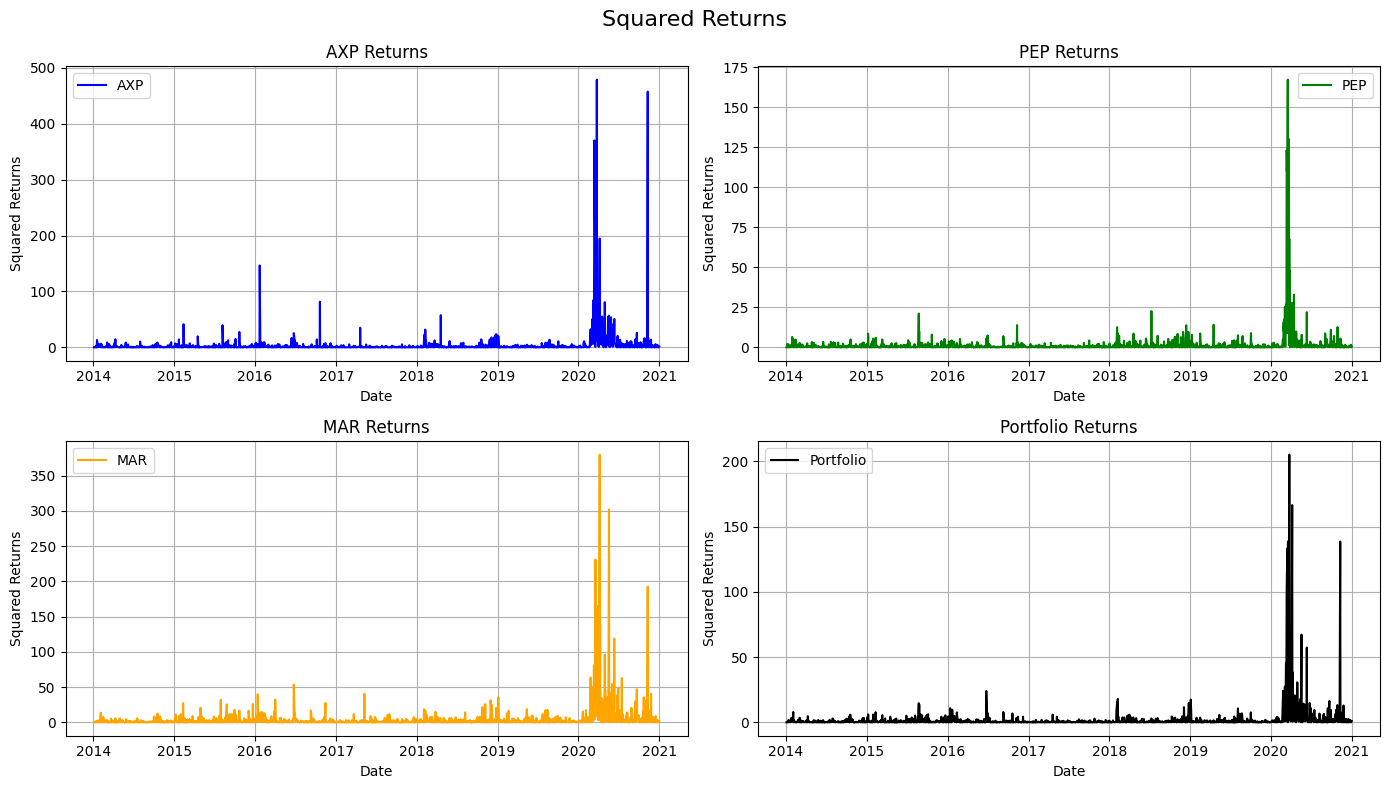

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0, 0].plot(portfolio['Date'], portfolio['AXP_rt']**2, label='AXP', color='blue')
axs[0, 0].set_title('AXP Returns')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Squared Returns')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(portfolio['Date'], portfolio['PEP_rt']**2, label='PEP', color='green')
axs[0, 1].set_title('PEP Returns')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Squared Returns')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(portfolio['Date'], portfolio['MAR_rt']**2, label='MAR', color='orange')
axs[1, 0].set_title('MAR Returns')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Squared Returns')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(portfolio['Date'], portfolio['Returns']**2, label='Portfolio', color='black')
axs[1, 1].set_title('Portfolio Returns')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Squared Returns')
axs[1, 1].legend()
axs[1, 1].grid(True)

fig.suptitle('Squared Returns', fontsize=16)
plt.tight_layout()
plt.show()

**AXP (American Express) Squared Returns:**

AXP exhibits several sharp spikes in squared returns, especially during 2020, reaching levels over 400. This indicates periods of extreme volatility, likely driven by market responses to economic disruptions during the pandemic. High squared returns reflect the magnitude of AXP’s fluctuations.

**PEP (PepsiCo) Squared Returns:**

PEP’s squared returns remain consistently low, with few peaks, reflecting its stability. However, in early 2020, there is a notable spike, although it’s relatively mild compared to AXP and MAR. PEP’s lower squared returns show it is less sensitive to market turbulence, reinforcing its role as a stable asset in the portfolio.

**MAR (Marriott International) Squared Returns:**

MAR shows significant spikes in squared returns, particularly in 2020, with values approaching 350. This reflects the severe impact of the pandemic on the hospitality sector, with MAR experiencing intense volatility. The high squared returns are indicative of sharp price changes as travel demand was heavily affected.

**Portfolio Squared Returns:**

The portfolio’s squared returns remain relatively low throughout, with some volatility spikes during market disruptions, particularly in 2020. While diversification reduces volatility compared to individual assets like AXP and MAR, the equal weighting does not fully neutralize market-wide shocks, as seen in the notable peaks.

**Next, we will compute the autocorrelation function (ACF) for the returns of the portfolio**

<Figure size 1400x1000 with 0 Axes>

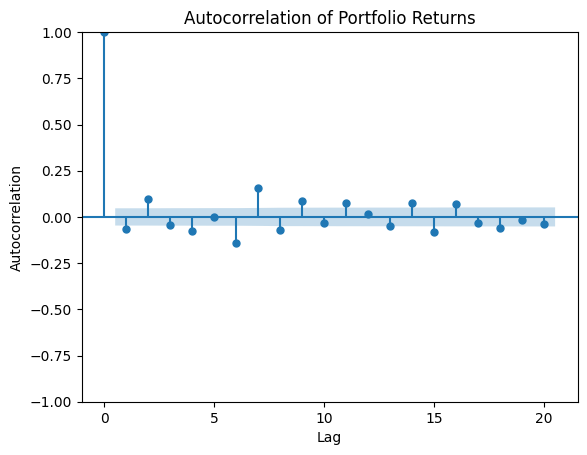

In [ ]:
# Plot the ACF of portfolio returns
plt.figure(figsize=(14, 10))
plot_acf(portfolio['Returns'].dropna(), lags=20)
plt.title('Autocorrelation of Portfolio Returns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show();

The **autocorrelation function (ACF)** plot for portfolio returns shows the correlation of the portfolio returns with its own past values at different lags:

- **Lag 0**: As expected, there is a strong correlation at lag 0 (autocorrelation of 1), as each return series is perfectly correlated with itself.

- **Subsequent Lags**: For lags beyond 0, autocorrelation values hover around zero, with minor positive and negative fluctuations that remain within the confidence bounds. This pattern indicates a lack of significant autocorrelation in portfolio returns over time, suggesting that past returns do not have a strong predictive power for future returns in this portfolio.

- **Implication**: The absence of significant linear autocorrelation suggests that the portfolio returns are approximately independent over time. However, it is important to note that this analysis only captures linear correlations; any non-linear dependencies would not be reflected here.

## 1.3 Perform the normality, Ljung-Box tests to check if the series is normally and independently distributed. Report the test statistic, the p-value and comment on your results. (2 marks)

**First, we will test whether the series follows a normal distribution**

We will initially examine the distribution of the portfolio returns by plotting a histogram

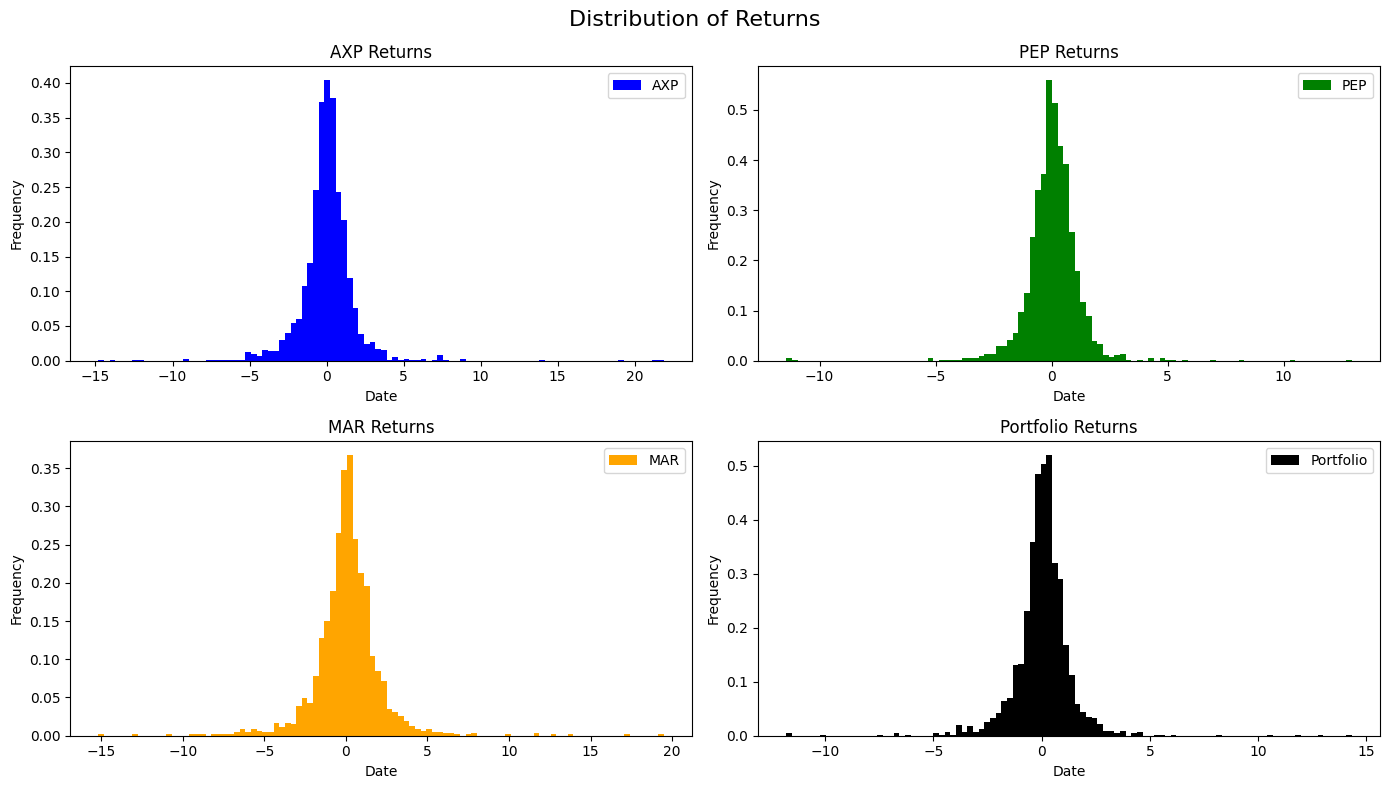

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0, 0].hist(portfolio['AXP_rt'], label='AXP', color='blue', bins = 100, density = True)
axs[0, 0].set_title('AXP Returns')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend()

axs[0, 1].hist(portfolio['PEP_rt'], label='PEP', color='green', bins = 100, density = True)
axs[0, 1].set_title('PEP Returns')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

axs[1, 0].hist(portfolio['MAR_rt'], label='MAR', color='orange', bins = 100, density = True)
axs[1, 0].set_title('MAR Returns')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend()

axs[1, 1].hist(portfolio['Returns'], label='Portfolio', color='black', bins = 100, density = True)
axs[1, 1].set_title('Portfolio Returns')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend()

fig.suptitle('Distribution of Returns', fontsize=16)
plt.tight_layout()
plt.show()

As we can see, the distribution has a sharp peak around the mean, with fatter tails compared to a normal distribution. This “leptokurtic” shape, characterized by a higher peak and fatter tails, indicates a greater frequency of returns close to the mean but also a higher occurrence of extreme values than expected under normality. While the plot is mostly centered around zero, there appears to be some asymmetry, with slightly more frequent occurrences on the right side. This potential skewness suggests that returns may not be perfectly symmetric.

We will now conduct normality tests to statistically validate our observation:

**Null Hypothesis (H₀)**: The sample data is drawn from a population that follows a normal distribution.

**Alternative Hypothesis (H₁)**: The sample data is not drawn from a population that follows a normal distribution.

**Interpretation**:
- **If p-value > 0.05**: Fail to reject the null hypothesis. Conclude that the sample data is likely drawn from a normally distributed population.

- **If p-value ≤ 0.05**: Reject the null hypothesis. Conclude that the sample data is not likely drawn from a normally distributed population.

In [ ]:
# Normality test for AXP return
AXP_normality_test = shapiro(portfolio['AXP_rt'].dropna())
AXP_normality_statistic = AXP_normality_test.statistic
AXP_normality_pvalue = AXP_normality_test.pvalue

# Normality test for PEP return
PEP_normality_test = shapiro(portfolio['PEP_rt'].dropna())
PEP_normality_statistic = PEP_normality_test.statistic
PEP_normality_pvalue = PEP_normality_test.pvalue

# Normality test for MAR return
MAR_normality_test = shapiro(portfolio['MAR_rt'].dropna())
MAR_normality_statistic = MAR_normality_test.statistic
MAR_normality_pvalue = MAR_normality_test.pvalue

# Normality test for portfolio return
normality_test = shapiro(portfolio['Returns'].dropna())
normality_statistic = normality_test.statistic
normality_pvalue = normality_test.pvalue

# Print test results
print("Normality Test (Shapiro-Wilk)")
print('\n')
print("AXP return: p-value:", AXP_normality_pvalue)
print(f"Is Normally Distributed? {'Yes' if AXP_normality_pvalue > 0.05 else 'No'}")
print('\n')
print("PEP return: p-value:", PEP_normality_pvalue)
print(f"Is Normally Distributed? {'Yes' if PEP_normality_pvalue > 0.05 else 'No'}")
print('\n')
print("MAR return: p-value:", MAR_normality_pvalue)
print(f"Is Normally Distributed? {'Yes' if MAR_normality_pvalue > 0.05 else 'No'}")
print('\n')
print("Portfolio return: p-value:", normality_pvalue)
print(f"Is Normally Distributed? {'Yes' if normality_pvalue > 0.05 else 'No'}")


Normality Test (Shapiro-Wilk)


AXP return: p-value: 1.0038426799062678e-44
Is Normally Distributed? No


PEP return: p-value: 4.1644106395135335e-41
Is Normally Distributed? No


MAR return: p-value: 2.1839439036686178e-37
Is Normally Distributed? No


Portfolio return: p-value: 3.5171235464391536e-42
Is Normally Distributed? No


Our observation is confirmed: none of the series follow a normal distribution.

**Next, we will examine whether the portfolio returns are independent or not**

The **Ljung-Box test** is used to check for the independence of residuals in a time series. It tests the null hypothesis that there is no autocorrelation up to a specified number of lags.

**Null Hypothesis (H₀)**: There is no autocorrelation in the time series at the specified lag.

**Alternative Hypothesis (H₁)**: There is autocorrelation in the time series at the specified lag.

**Interpretation**:
- **If p-value ≤ 0.05**: Reject the null hypothesis. Conclude that there is significant autocorrelation in the time series at the specified lag.

- **If p-value > 0.05**: Fail to reject the null hypothesis. Conclude that there is no significant autocorrelation in the time series at the specified lag.

In [ ]:
# Independence test (Ljung-Box test)
independence_test = acorr_ljungbox(portfolio['Returns'], lags=10)
independence_pvalue = independence_test.lb_pvalue

# Print test results
print("Independence Test (Ljung-Box)")
print("p-values: \n",independence_pvalue)

Independence Test (Ljung-Box)
p-values: 
 1     8.390977e-03
2     1.207486e-05
3     8.404227e-06
4     1.662564e-07
5     5.539268e-07
6     7.220040e-14
7     1.954375e-22
8     1.242080e-23
9     1.186217e-25
10    1.823533e-25
Name: lb_pvalue, dtype: float64


The ACF plot upper shows minimal autocorrelation in the time series of portfolio returns, suggesting that each individual lag does not show strong autocorrelation. However, the Ljung-Box test results have extremely low p-values, which means that portfolio’s returns do not fully follow a random walk, and there might be underlying patterns or dependencies in the data. Here’s my analysis of why this might occur:

**Non-Linear Dependencies:**

- The ACF and Ljung-Box test are primarily linear methods, meaning they’re good for detecting linear patterns of dependence. If there are non-linear dependencies that the ACF doesn’t capture, the Ljung-Box test might still detect them due to the cumulative nature of its statistic.

# Question 2: (3 marks)

Using the three series above :



### 2.1 Estimate the EWMA, GARCH (1,1), GJR(1,1,1) models with Student’s t distribution assumption. Report the estimation result and some comments. (1 mark)

In [ ]:
returns = portfolio['Returns'].copy().dropna()
returns_os = portfolio_os['Returns'].copy().dropna()

**First, we will apply the EWMA model to fit the data and report its results.**

EWMA, or Exponentially Weighted Moving Average, is a statistical technique often used in time series analysis to smooth data and emphasize more recent observations.

EWMA volatility is an approach to calculate volatility that emphasizes recent price movements, making it more responsive to shifts in market behavior.

**EWMA Volatility Calculation**
To compute EWMA volatility, we rely on the exponentially weighted average of squared returns. Here's the step-by-step breakdown:

1. Select a Decay Factor (λ):

- The decay factor, λ, generally lies between 0 and 1 and determines how quickly the influence of older observations fades.

2. Apply the Recursive Formula for EWMA Variance:

- If $r_t$ represents the return at time $t$, the EWMA variance $σ_t^2$ at time &t& is calculated as:

  $σ_t^2 = (1-λ).r_{t-1}^2 + λ.σ_{t-1}^2$

  Here, (1-λ) weights the current return, λ while controls how much of the previous variance (EWMA variance from the last period) carries over.

- Calculate EWMA Volatility:

  Volatility $σ_t^2$ is simply the square root of the EWMA variance:
  
  $σ_t = \sqrt{σ_t^2}$

  This approach smooths out the variance, giving a more stable measure of risk while adapting to new data with each time step.


Given the absence of a built-in EWMA model in Python, I have implemented an EWMA class

In [ ]:
class EWMA:

    def __init__(self, sq_rets, lam):
        self.sq_rets = sq_rets
        self.lam = lam
        self.EWMA = None

    def fit(self):

        sq_ret = self.sq_rets.values
        lam = self.lam
        EWMA_var = np.zeros(len(sq_ret))
        EWMA_var[0] = sq_ret[0]  # set initial variance based on the first squared return

        for r in range(1, len(sq_ret)):
            EWMA_var[r] = (1-lam)*sq_ret[r] + lam*EWMA_var[r-1] # compute EWMA variance

        EWMA_vol = np.sqrt(EWMA_var)
        self.EWMA = pd.Series(EWMA_vol, index=self.sq_rets.index, name='EWMA Vol {}'.format(lam))
        return self.EWMA

    def compute_log_likelihood(self):

        sq_rets = self.sq_rets
        residuals = sq_rets/self.EWMA
        N = len(residuals) # number of residuals
        sigma2 = np.var(residuals) # variance of the residuals

        # the log-likelihood formula for normally distributed residuals
        log_likelihood = (-0.5 * N * np.log(2 * np.pi) - 0.5 * N * np.log(sigma2) - (0.5 / sigma2) * np.sum(residuals ** 2))

        return log_likelihood

    def calculate_aic_bic(self, k=1):

        N = len(self.sq_rets)
        log_likelihood = self.compute_log_likelihood()
        # AIC formula: 2*k - 2*log_likelihood
        AIC = 2 * k - 2 * log_likelihood

        # BIC formula: k*log(N) - 2*log_likelihood
        BIC = k * np.log(N) - 2 * log_likelihood

        return AIC, BIC

In [ ]:
# EWMA model
EWMA_model = EWMA(returns**2, 0.94)
EWMA_result = EWMA_model.fit()
EWMA_AIC = EWMA_model.calculate_aic_bic()[0]
EWMA_BIC = EWMA_model.calculate_aic_bic()[1]

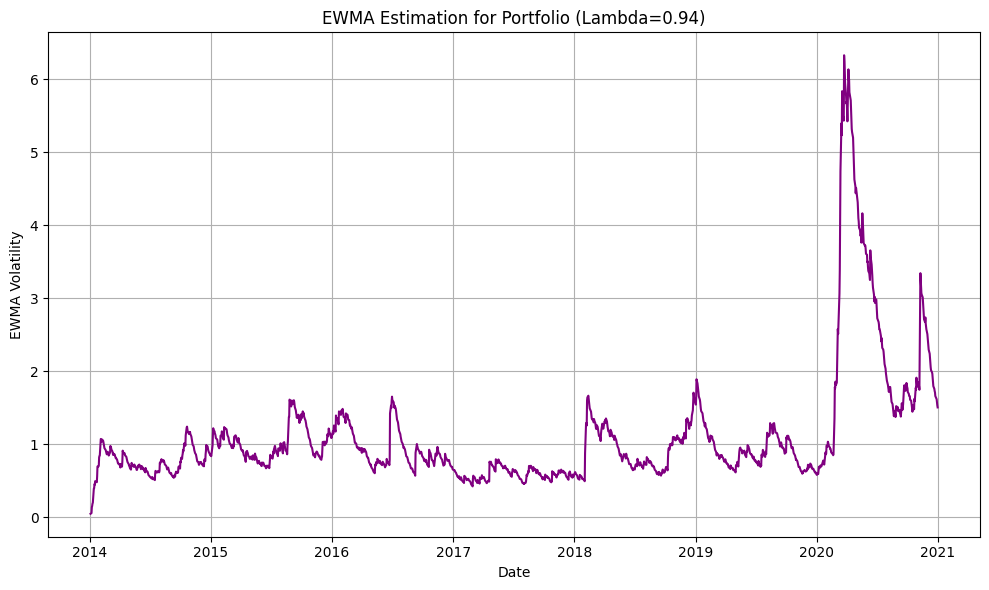

In [ ]:
# plot the model results
plt.figure(figsize=(10, 6))
plt.plot(portfolio['Date'], EWMA_result, label='PORT', linestyle='-', color='purple')
plt.title('EWMA Estimation for Portfolio (Lambda=0.94)')
plt.xlabel('Date')
plt.ylabel('EWMA Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

The EWMA volatility plot for the portfolio reveals periods of stability and heightened risk over time, using a smoothing parameter of $λ = 0.94$ to weight recent observations more heavily. From 2014 to late 2019, the volatility remains relatively low, fluctuating between 0.5 and 2, with minor rises likely due to routine market variations. This indicates a period of relative market stability, where portfolio risks were lower and more predictable.

However, in early 2020, volatility spikes dramatically, exceeding $6$, which aligns with the onset of the COVID-19 pandemic and the resulting financial market turmoil. This sudden increase highlights the model's sensitivity to market shocks, capturing the significant rise in portfolio risk during periods of uncertainty.

Following the 2020 peak, volatility decreases but does not return to its pre-2020 stability, suggesting that residual market uncertainty or risk persists. Although it declines substantially from the COVID-19 peak, it remains above prior levels, reflecting continued adjustments in the market environment. This volatility measure is particularly valuable for risk management, as it enables portfolio managers to respond dynamically to changing market conditions and adjust exposure during times of elevated risk.

**Second, we employ the GARCH(1,1) model with Student's t distribution
assumption to fit the data and conduct the analysis.**

The GARCH(1,1) model—short for Generalized Autoregressive Conditional Heteroskedasticity—is a widely used statistical model for estimating and forecasting volatility. The GARCH model captures periods of high and low volatility, by allowing volatility to change over time based on recent observations and previous volatility levels.

Variance Equation in GARCH(1,1):

- In GARCH(1,1), the conditional variance of returns at time is given by:
  
  $σ_t^2 = \alpha_0 + \alpha_1.r_{t-1}^2 + β_1.σ_{t-1}^2$

- Here:
  + $α_0$ is the long-term average variance
  + $α_1$ controls the influence of the previous period's squared return (also called the ARCH term).
  + $β_1$ controls the impact of the previous period’s variance (the GARCH term).

- This recursive formula updates the variance each period, making it highly responsive to recent volatility shocks.


In [ ]:
# GARCH(1,1) model
garch_model = arch.arch_model(returns, vol='Garch', p=1, q=1, dist='t')
garch_results = garch_model.fit(update_freq=5)
print("GARCH(1,1) Model:\n", garch_results.summary())

Iteration:      5,   Func. Count:     44,   Neg. LLF: 2463.4001926541546
Iteration:     10,   Func. Count:     76,   Neg. LLF: 2411.360796752715
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2411.360796752715
            Iterations: 11
            Function evaluations: 81
            Gradient evaluations: 11
GARCH(1,1) Model:
                         Constant Mean - GARCH Model Results                         
Dep. Variable:                      Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2411.36
Distribution:      Standardized Student's t   AIC:                           4832.72
Method:                  Maximum Likelihood   BIC:                           4860.09
                                              No. Observations:                 1762
Date:                      Sat, 

This GARCH(1,1) model output provides insights into the volatility structure of a returns series. Here’s a breakdown of the key components:

**Mean Model**

The mean return (𝜇) is estimated at 0.0989 with a very low p-value ($1.88e-08$), suggesting it is statistically significant. This indicates a small but consistent mean return over the period analyzed.

**Volatility Model**

- Omega (ω): The constant term in the volatility equation is 0.0372, and it is statistically significant (p-value < 0.0005). This term represents the baseline level of variance when there are no recent shocks.
- Alpha (α): This coefficient, at 0.1541, represents the impact of recent shocks on volatility (also known as the ARCH effect). The statistically significant p-value (< 0.0001) suggests that recent returns' squared values influence current volatility.
- Beta (β): At 0.8255, this parameter reflects the persistence in volatility (also known as the GARCH effect). A high beta value, close to 1, indicates that shocks to volatility decay slowly, meaning volatility is highly persistent. This is typical in financial time series, where high or low volatility clusters over time.

The sum of $α+β=0.9796$, close to 1, implies that volatility is mean-reverting but does so slowly, indicating a persistent volatility pattern over time.

**Model Diagnostics**

AIC and BIC values (4830.88 and 4858.25, respectively) are provided for model comparison, where lower values indicate better model fit.
The very low p-values across parameters indicate that each component (mean, volatility, and distribution) significantly contributes to the model.

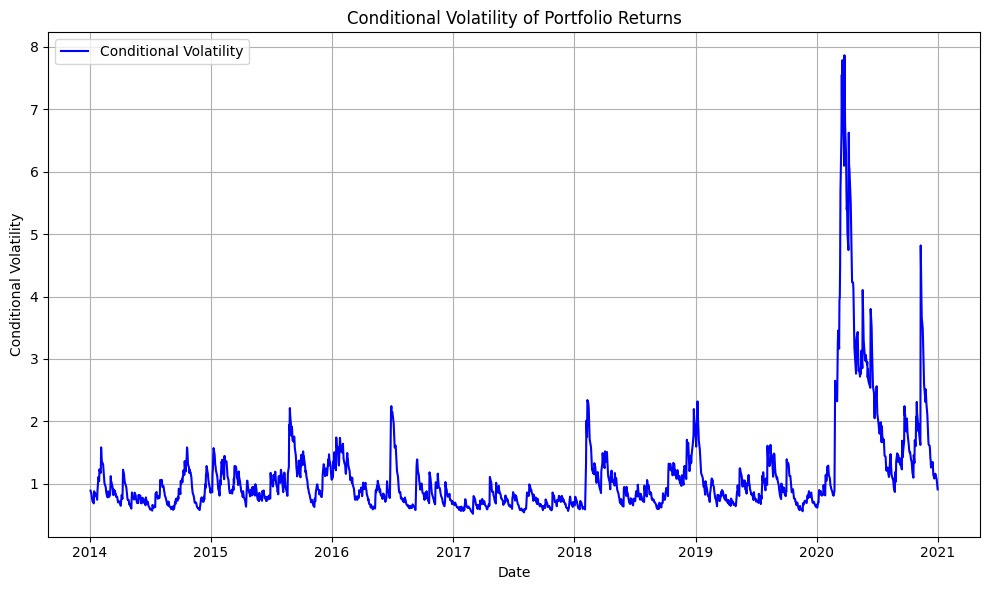

In [ ]:
# Get the conditional volatility (square root of variance)
conditional_volatility = garch_results.conditional_volatility

plt.figure(figsize=(10, 6))
plt.plot(portfolio['Date'], conditional_volatility, label='Conditional Volatility', color='blue')
plt.title('Conditional Volatility of Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This plot shows the conditional volatility estimated by the GARCH(1,1) model over time. From 2014 to 2019, volatility remains relatively low and stable, with occasional spikes reaching up to 2, likely reflecting normal market fluctuations.

In early 2020, we see a dramatic spike, with volatility peaking above 8, which aligns with the onset of the COVID-19 pandemic and the resulting market disruption. After this peak, volatility gradually declines but remains more elevated and variable compared to pre-2020 levels, indicating that the market has not fully stabilized.

This GARCH model captures both the clustering and persistence of volatility, which is typical in financial time series, especially during periods of economic stress.

**Third, we apply the GJR-GARCH model to fit the data, allowing us to capture asymmetries in volatility, particularly the leverage effect where negative shocks may increase volatility more than positive ones**

The GJR-GARCH model (Glosten-Jagannathan-Runkle GARCH) is an extension of the standard GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model. It introduces an asymmetric effect to account for different impacts of positive and negative shocks on volatility.

1. Asymmetry in Volatility Response:

- Unlike the standard GARCH model, the GJR-GARCH model accounts for the fact that "bad news" (negative returns) often has a greater impact on volatility than "good news" (positive returns).

- This effect, called the leverage effect, reflects that investors tend to react more strongly to negative information, causing volatility to spike.

2. Model Specification:

- The GJR-GARCH(1,1) model, a common form of this model, can be specified as:

  $σ_t^2 = ω + \alpha.\epsilon_{t-1}^2 + \gamma.\epsilon_{t-1}^2.I_{t-1} + β.σ_{t-1}^2$

  where:
  + $σ_t^2$ is the conditional variance (volatility) at time $t$
  + $ω$ is a constant term
  + $α$ is the parameter for the ARCH term (impact of recent shocks)
  + $γ$ captures the asymmetric effect, $I_{t-1}$ with as an indicator function that equals 1 if $\epsilon_{t-1} < 0$ (negative shock) and 0 otherwise
  + $β$ is the GARCH parameter representing the persistence in volatility.

- The term $\gamma.\epsilon_{t-1}^2.I_{t-1}$ adds an extra component to volatility if the previous shock was negative, thus increasing volatility more after negative returns.

In [ ]:
# GJR(1,1,1) model
gjr_model = arch.arch_model(returns, vol='Garch', p=1, q=1, o=1, dist='t')
gjr_results = gjr_model.fit(update_freq=5)
print("GJR(1,1,1) Model:\n", gjr_results.summary())

Iteration:      5,   Func. Count:     45,   Neg. LLF: 3606.495168014285
Iteration:     10,   Func. Count:     87,   Neg. LLF: 2390.3141784902596
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2390.3141784902596
            Iterations: 11
            Function evaluations: 93
            Gradient evaluations: 11
GJR(1,1,1) Model:
                       Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                      Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2390.31
Distribution:      Standardized Student's t   AIC:                           4792.63
Method:                  Maximum Likelihood   BIC:                           4825.47
                                              No. Observations:                 1762
Date:                      Sat,

Output presents a GJR-GARCH(1,1,1) model, providing insights into both the mean return and volatility structure of the returns series, while accounting for asymmetry in volatility responses to positive and negative shocks.

**Mean Model**

- The estimated mean return ($𝜇$) is 0.0722, with a low p-value ($8.58e-05$), indicating statistical significance. This suggests a small but consistent mean return across the sample period.

**Volatility Model**

- Omega ($𝜔$): The baseline volatility level is estimated at 0.0339, with a highly significant p-value (<0.0001). This represents the constant term in the conditional variance.
- Alpha ($𝛼$): At 0.0294, this coefficient measures the impact of recent shocks on volatility. The statistically significant p-value ($3.58e-02$) suggests that recent returns’ squared values have a measurable effect on current volatility, albeit relatively modest in scale.
- Gamma ($𝛾$): The gamma parameter (0.1955) captures the asymmetry, showing how negative shocks (bad news) have a greater effect on volatility than positive shocks. Its significant p-value ($9.76e-08$) confirms that negative returns indeed increase volatility more than positive returns of the same size, a typical leverage effect in financial series.
- Beta ($β$): The persistence parameter is high at 0.8467, indicating that volatility is highly persistent, as shocks to volatility tend to decay slowly over time. This parameter has an extremely low p-value, confirming its significance.
  
  The sum $α + β + γ/2$ =0.97485, close to 1, suggests high persistence, meaning that volatility shocks will have a prolonged effect on future volatility.

**Model Diagnostics**

- AIC and BIC values (4791.39 and 4824.24, respectively) offer metrics for comparing this model to others, with lower values indicating better fit.
- All key parameters in the volatility model are highly significant, suggesting a well-fitted model.

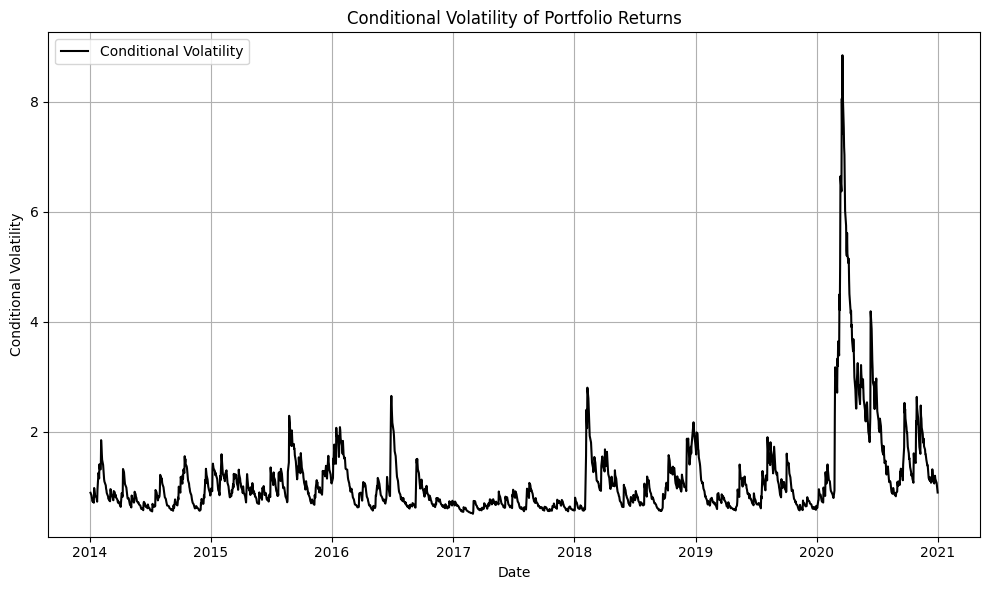

In [ ]:
# Get the conditional volatility (square root of variance)
conditional_volatility = gjr_results.conditional_volatility

plt.figure(figsize=(10, 6))
plt.plot(portfolio['Date'], conditional_volatility, label='Conditional Volatility', color='black')
plt.title('Conditional Volatility of Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The conditional volatility plot from the GJR-GARCH(1,1,1) model shows distinct periods of stability and heightened risk. Between 2014 and 2019, volatility remains low, with occasional spikes up to 2, reflecting minor fluctuations typical in relatively calm market conditions.

In early 2020, there’s a sharp surge in volatility, peaking above 8, which aligns with the COVID-19 crisis. This spike demonstrates the model's ability to capture the asymmetric impact of large, negative shocks on volatility, as expected from the GJR-GARCH framework.

Post-2020, volatility decreases but remains above pre-2020 levels, indicating residual market uncertainty. This pattern confirms the model’s responsiveness to volatility clustering and the asymmetric effects of negative shocks, making it suitable for understanding risk dynamics in turbulent periods.

### 2.2 Select the best model among the EWMA, the GARCH (1,1) and the GJR models using AIC and SBIC. (1 mark)

**Description of Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC)**

Both the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) are metrics used for model selection. They help in identifying the best model among a set of candidate models by balancing model fit and complexity.

**Akaike Information Criterion ($AIC$)**

- Definition: $AIC$ is a measure of the relative quality of a statistical model for a given dataset. It balances the goodness of fit of the model with its complexity by incorporating the number of parameters.

- Formula: $AIC = -2ln(L) + 2k$
  - $L$: The maximum value of the likelihood function of the model.
  - $k$ = The number of parameters in the model.
  - $n$: The number of observations in the dataset.

- Interpretation:

  - Model Fit: The term $-2ln(L)$ rewards goodness of fit.
  - Model Complexity: The term $2k$ penalizes the number of parameters, discouraging overfitting.
  - Lower $AIC$: Models with lower $AIC$ values are preferred. It indicates a better balance between model fit and complexity.

- Usage: $AIC$ is often used in time series analysis, regression models, and other statistical modeling approaches to compare different models.

**Bayesian Information Criterion ($BIC$)**

- Definition: $BIC$  is another criterion for model selection that includes a stronger penalty for models with more parameters compared to $AIC$. It is derived from Bayesian probability and is also known as the Schwarz Criterion.

- Formula: $BIC=−2ln(L)+kln(n)$

  - $L$: The maximum value of the likelihood function of the model.
  - $k$ : The number of parameters in the model.
  - $n$: The number of observations in the dataset.

- Interpretation:

  - Model Fit: The term $−2ln(L)$ rewards goodness of fit.

  - Model Complexity: The term $kln(n)$ penalizes the number of parameters more heavily than $AIC$, especially when the sample size $n$ is large.

  - Lower $BIC$: Models with lower $BIC$ values are preferred. It suggests a better balance between model fit and complexity, with a stronger preference for simpler models compared to $AIC$.

- Usage: $BIC$ is widely used in various statistical modeling contexts, including time series analysis, regression, and more, particularly when the sample size is large.

**Comparison between $AIC$ and $BIC$**

- Penalty for Complexity: $BIC$ imposes a stronger penalty on the number of parameters than $AIC$. This makes $BIC$ more conservative in model selection, favoring simpler models more strongly.
- Sample Size Influence: The penalty term in $BIC$ ($kln(n$)) grows with the sample size, making it more sensitive to model complexity in larger datasets. $AIC$’s penalty term ($2k$) is independent of the sample size.
- Model Selection: Both criteria aim to select models that achieve a balance between goodness of fit and parsimony. However, $AIC$ might select a more complex model if the improvement in fit justifies the added complexity, while $BIC$ is more likely to choose simpler models unless the fit improvement is substantial.

In [ ]:
# Calculate AIC and SBIC for each model
aic_values = [EWMA_AIC, garch_results.aic, gjr_results.aic]
sbic_values = [EWMA_BIC, garch_results.bic, gjr_results.bic]

# Find the index of the minimum AIC and SBIC values
best_aic_model = aic_values.index(min(aic_values))
best_sbic_model = sbic_values.index(min(sbic_values))

# Print the selected models
print("Best Model (AIC):", ['EWMA', 'GARCH(1,1)', 'GJR(1,1,1)'][best_aic_model])
print("Best Model (SBIC):", ['EWMA', 'GARCH(1,1)', 'GJR(1,1,1)'][best_sbic_model])

Best Model (AIC): GJR(1,1,1)
Best Model (SBIC): GJR(1,1,1)


**The best fit model is GJR-GARCH(1,1,1)**

- Now, I will conduct the VaR backtesting on the GJR-GARCH(1,1,1)

### 2.3 Perform backtesting on the VaR estimated on the best model above. (1 mark)

I've coded a function to calculate Value at Risk (VaR), which measures the potential loss in the portfolio value over a in-sample time horizon, given a certain confidence level.

In [ ]:
def VaR_test(returns, date, conditional_volatility):

  # Set confidence level for VaR
  confidence_level = 0.05  # 5% VaR

  # Calculate VaR using the model estimates
  VaR = norm.ppf(confidence_level) * conditional_volatility

  # Compare actual returns with VaR estimates
  violations = returns < VaR

  # Calculate backtesting metrics
  n_obs = len(returns)
  n_violations = np.sum(violations)
  expected_violations = n_obs * confidence_level
  observed_violate_rate = n_violations/n_obs

  # Binomial test for backtesting (Kupiec's test)
  p_value = 1-norm.cdf(abs((n_violations - expected_violations) / np.sqrt(expected_violations * (1 - confidence_level))))

  LR_pof = 2 * (n_violations * (np.log(observed_violate_rate) - np.log(confidence_level)) +
                (n_obs - n_violations) * (np.log(1 - observed_violate_rate) - np.log(1 - confidence_level)))

  # Compute the p-value from the chi-squared distribution with 1 degree of freedom
  p_value = 1 - stats.chi2.cdf(LR_pof, df=1)


  # Print backtesting results
  print(f"Number of violations: {n_violations}")
  print(f"Expected violations (at {confidence_level*100}%): {expected_violations}")
  print(f"P-value (Kupiec's test): {p_value}")


  plt.figure(figsize=(12, 6))
  plt.plot(date, returns, label='Actual Returns', color='b')
  plt.plot(date, VaR, label=f'VaR (confidence level: {confidence_level*100}%)', color='r', linestyle='--')
  plt.title('Actual Returns vs VaR Estimates')
  plt.xlabel('Date')
  plt.ylabel('Returns')
  plt.legend(loc = 'upper right')
  plt.grid(True)
  plt.tight_layout()
  plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
  plt.gca().yaxis.set_major_locator(plt.MaxNLocator(10))
  plt.axhline(0, color='black', linewidth=0.5)
  plt.show()

Now, let's calculate the Value at Risk (VaR) using the fitted GJR-GARCH(1,1,1) model and compare it to the actual returns. This comparison will help us assess the model's accuracy in capturing the potential risk of losses.

We can analyze the frequency of breaches, where actual returns exceed the calculated VaR, to evaluate the model's effectiveness in risk management.

Number of violations: 85
Expected violations (at 5.0%): 88.10000000000001
P-value (Kupiec's test): 0.7332807652276803


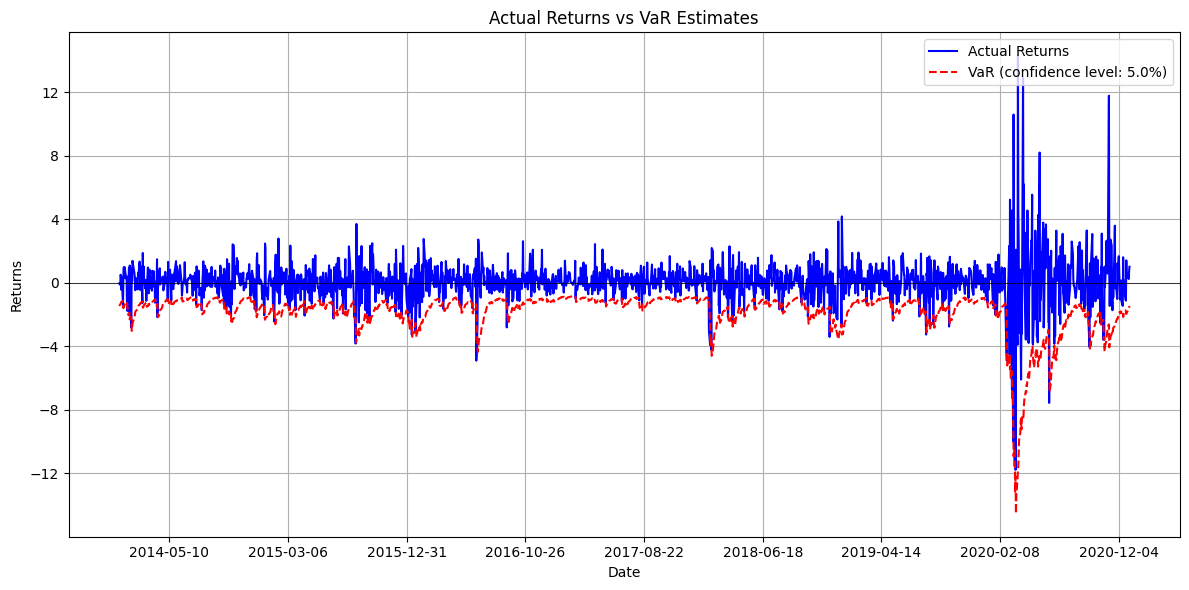

In [ ]:
VaR_test(returns, portfolio['Date'], pd.Series(gjr_results.conditional_volatility.dropna()))

This plot displays the Value at Risk (VaR) estimates at a 5% confidence level (dashed red line) alongside actual portfolio returns (solid blue line) based on the GJR-GARCH(1,1,1) model. The VaR line represents the threshold below which only 5% of returns are expected to fall, thus serving as a risk boundary.

- **VaR Violations**:

There are 85 observed violations (cases where actual returns fall below the VaR threshold) compared to an expected 88.1, based on the 5% confidence level. This alignment suggests that the VaR model is well-calibrated, capturing risk reasonably accurately.
The Kupiec's test p-value (0.7333) indicates no significant difference between the observed and expected violations, supporting the model’s validity at the 5% confidence level.

- **Periods of High Volatility**:

During periods of market turmoil, such as the sharp decline around early 2020, the actual returns exhibit extreme deviations, pushing below the VaR threshold multiple times. The GJR-GARCH model, which accounts for asymmetric shocks, adapts well but shows limits in capturing extreme events fully.

- **Overall Performance**:

The model’s VaR estimates closely follow the volatility pattern of returns, adjusting upward or downward as market conditions change. This adaptability indicates the GJR-GARCH model’s effectiveness in capturing risk dynamics in volatile markets.

## Question 3: (2 marks) Fitting the multivariate GARCH frameworks: Copula-DCC-GARCH.


The DCC-GARCH (Dynamic Conditional Correlation GARCH) model is an extension of the GARCH model that enables the modeling of time-varying correlations between multiple assets or financial variables. Unlike traditional GARCH models, which only model individual asset volatility, the DCC-GARCH models the conditional covariance matrix across multiple assets.
This allows it to capture time-varying correlations, which reflect the dynamic nature of relationships between assets, especially during volatile or crisis periods.

**Model Structure**

1. **Decomposition:**

- The DCC model decomposes the covariance matrix of asset returns into conditional standard deviations and a time-varying correlation matrix.
- Let $r_t$ be an N-dimensional vector of asset returns at time $t$.

2. **Conditional Covariance Matrix:**

  $H_t = D_t R_t D_t$

- $H_t$: Conditional covariance matrix of returns at time
- $R_t$: Diagonal matrix of conditional standard deviations

**The DCC-GARCH model can be futher decomposed into two-step model:**

1. **Step 1: Univariate GARCH(1,1) for Each Asset**

  For each asset $i$, the GARCH(1,1) model estimates the conditional variance $h_{i,t}$ as follows:

  $h_{i,t}^2 = ω_i + \alpha_i.\epsilon_{i,t-1}^2 + β_i.h_{i,t-1}^2$

  where:
  - $ω_i$ is a constant term
  - $α_i$ represents the response to recent shocks (ARCH term)
  - $β_i$ represents the persistence of past volatility (GARCH term)
  - $\epsilon_{i,t}$ is the error term or innovation for asset $i$, at time $t$, which follows $\epsilon_{i,t} = z_{i,t}.\sqrt{h_{i,t-1}}$,  where $z_{i,t}$ are i.i.d. standard normal or Student’s t-distributed.

2. **Step 2: Dynamic Conditional Correlation (DCC)**

  Once the conditional variances for each asset are estimated, the DCC model estimates the conditional correlation matrix $R_t$ using the standardized residuals:

- Standardized Residuals:
  $z_{i,t} = \frac{\epsilon_{i,t}}{\sqrt{h_{i,t}}}$

- Correlation Matrix Evolution: The dynamic correlation matrix $R_t$ is calculated as follows:

  $Q_t = (1-a-b).\overline{Q} + a.z_{t-1}.z_{t-1}^T + Q_{t-1}$
  
  where:
   - $Q_t$ is the time-varying covariance matrix of the standardized residuals
   - $\overline{Q}$ is the unconditional covariance matrix of the standardized residuals ${z_{i,t}}$
   - $a$ and $b$ are parameters controlling the weight of past shocks and past correlations, respectively, with $a + b < 1$ for stationary.

- Normalizing to Obtain Correlation Matrix $R_t$: The conditional correlation matrix $R_t$ is obtained by normalizing $Q_t$ as follows:

  $R_t = diag(Q_t)^{-1/2}.Q_t.diag(Q_t)^{-1/2}$

  Here,  $diag(Q_t)^{-1/2}$ is a diagonal matrix containing the square roots of the diagonal elements $Q_t$, which ensures that the correlations in $R_t$ are properly scaled between -1 and 1.




**Limitations of DCC-GARCH and the Need for Copulas**

While the DCC-GARCH model captures linear, time-varying correlations between assets, it may not adequately capture non-linear dependencies or tail dependence (the tendency for assets to co-move in extreme market conditions). Copulas are introduced to address this.

A copula is a function that links marginal distributions of individual assets to form a joint distribution, capturing dependency structures without assuming linear correlation.

### 3.1 Estimate and report the results. (1 mark)

Given the absence of a built-in DCC model in Python, I have implemented a Copula-DCC-GARCH as the following:

In [ ]:
#--------------------------------------------------------------------------------- MATRIX-GENERATING FUNCTIONS --------------------------------------------------------------------

def Q_average(tr):
    # return average of outer product of [eT-1,...e0]
    # et = [r(1t)/s(1t),...r(nt)/s(nt)]
    T = tr.shape[1]
    n = tr.shape[0]
    sum = np.zeros([n,n])
    for i in range(T):
        sum += np.outer(tr[:,i],tr[:,i])
    return sum/T

def Q_gen(tr,ab):
    # generate [Q0,...QT-1] -- assume Q0 = Q_int
    Q_int = Q_average(tr)
    Q_list = [Q_int]
    T = tr.shape[1]
    a = ab[0]
    b = ab[1]
    for i in range(1,T):
        et_1 = tr[:,i-1]
        Qt_1 = Q_list[i-1]
        Qt = (1.0-a-b)*Q_int + a*np.outer(et_1,et_1) + b*Qt_1
        Q_list = Q_list + [Qt]
    return Q_list

def R_gen(tr,ab): #Qt --> Rt
    # output [R0,...RT-1]
    Q_list = Q_gen(tr,ab)
    R_list = []
    n = Q_list[0].shape[0]
    for Qt in Q_list:
        Q_star = np.sqrt(np.diag(1/np.diag(Qt + 1e-10)))
        Rt = Q_star @ Qt @ Q_star
        R_list = R_list + [Rt]
    return R_list

def D_gen(sigma):
    D_list = np.array([np.diag(sigma[:, i]) for i in range(sigma.shape[1])])
    return D_list

def H_gen(D, R):
    H_list = np.array([np.dot(np.dot(D[i], R[i]), D[i]) for i in range(len(R))])
    return H_list

def H_sqrt_gen(H):
    H_sqrt_list = np.array([np.linalg.cholesky(H[i]) for i in range(len(H))])
    return H_sqrt_list


#----------------------------------------------------------------------------- CORRELATION-MATRIX FUNCTIONS -----------------------------------------------------------------------------------

def vecl(matrix):
    lower_matrix = np.tril(matrix,k=-1)
    array_with_zero = np.matrix(lower_matrix).A1

    array_without_zero = array_with_zero[array_with_zero!=0]

    return array_without_zero

def Corr_data(tr, ab):
    N, T = int(tr.shape[0]), int(tr.shape[1])
    veclRt =  np.zeros((T, int(N*(N-1)/2)))
    Rt= R_gen(tr,ab)
    for j in range(0,T):
      veclRt[j, :] = vecl(Rt[j])
    return veclRt

#------------------------------------------------------------------------------ LOSS-FUNCTIONS -------------------------------------------------------------------------------------------------

# This is loss function
def loglike_norm_dcc_copula(ab, udata):
    N, T = int(udata.shape[0]), int(udata.shape[1])
    llf = np.zeros((T,1))
    trdata = np.array(norm.ppf(udata), ndmin=2)

    Rt =  R_gen(trdata, ab)

    for i in range(0,T):
        llf[i] = -0.5* np.log(np.linalg.det(Rt[i]))
        llf[i] = llf[i] - 0.5 *  np.matmul(np.matmul(trdata[:,i] , (np.linalg.inv(Rt[i]) - np.eye(N))) ,trdata[:,i].T)
    llf = np.sum(llf)

    return -llf

#------------------------------------------------------------------------------- COPULA-FUNCTIONS ----------------------------------------------------------------------------------------------

# Transform t-distribution to a uniform distribution
def garch_t_to_u(rets, garch_results):
    mu = garch_results.params['mu']
    nu = garch_results.params['nu']
    est_r = rets - mu
    h = garch_results.conditional_volatility
    std_res = est_r / h
    std_res = garch_results.std_resid
    udata = t.cdf(std_res, nu)
    return udata


After build these basic functions, I create a DCC class incorporating Copula (Copula-DCC-GARCH)

In [ ]:
class DCC():

    def __init__(self, max_itr=2):
        self.max_itr = max_itr
        self.ab = np.array([0.05, 0.95])
        self.method =  'SLSQP'
        self.Qt = None
        self.Rt = None
        self.Dt = None
        self.Ht = None
        self.H_sqrt_t = None
        self.loss_func = None
        def ub(x):
            return 1. - x[0] - x[1]
        def lb1(x):
            return x[0]
        def lb2(x):
            return x[1]
        self.cons = [{'type':'ineq', 'fun':ub},{'type':'ineq', 'fun':lb1},{'type':'ineq', 'fun':lb2}]
        self.bnds = ((0, 0.5), (0, 0.9997))
        self.epsilon = None

    def set_ab(self,ab): # ndarray
        self.ab = ab

    def set_method(self,method):
        self.method = method

    def set_loss(self, loss_func):
        self.loss_func = loss_func

    def get_loss_func(self):
        if self.loss_func is None:
            raise Exception("No Loss Function Found!")
        else:
            return self.loss_func

    def run_garch_on_return(self, rets):
        udata_list = []
        model_parameters = {}
        for x in rets:
            am = arch.arch_model(rets[x], vol='Garch', p=1, q=1, o=1, dist = 't')
            stock_code = x.split('_')[0]
            model_parameters[stock_code] = am.fit(disp='off')
            udata = garch_t_to_u(rets[x], model_parameters[stock_code])
            udata_list.append(udata)
        udata_list = np.array(udata_list)
        return udata_list, model_parameters

    def fit(self, train_data):

        udata_list, model_parameters = self.run_garch_on_return(train_data)

        tr = udata_list

        # Optimize using scipy and save theta
        tr_losses = []
        j = 0
        count = 0
        while j < self.max_itr:
            j += 1
            ab0 = np.array(self.ab)
            res = minimize(self.get_loss_func(), ab0, args = (tr,), bounds=self.bnds, constraints=self.cons)
            ab = res.x
            self.set_ab(ab)

            tr_loss = self.get_loss_func()(ab,tr)
            tr_losses.append(tr_loss)

        print("Successfully Trained!")

        epsilon = np.array(norm.ppf(udata_list), ndmin=2)
        sigma = np.array([np.array(model_parameters[i.split('_')[0]].conditional_volatility) for i in train_data])
        self.epsilon = epsilon
        self.Ht = self.H_t(epsilon, sigma)

        return tr_losses

    def Ht_forecast(self, test_data):
        udata_list, model_parameters = self.run_garch_on_return(test_data)
        epsilon = np.array(norm.ppf(udata_list), ndmin=2)
        sigma = np.array([np.array(model_parameters[i.split('_')[0]].conditional_volatility) for i in test_data])
        H_t_forecasted = self.H_t(epsilon, sigma)
        return H_t_forecasted

    def Q(self,y):
        self.Qt = np.array(Q_gen(y,self.ab))
        return self.Qt

    def Q_bar(self,y):
        return Q_average(y)

    def R_t(self, y):
        self.Rt = np.array(R_gen(y,self.ab))
        return self.Rt

    def D_t(self, sigma):
        self.Dt = D_gen(sigma)
        return self.Dt

    def H_t(self, y, sigma):
        Dt = np.array(D_gen(sigma))
        Rt = np.array(R_gen(y,self.ab))
        Ht = H_gen(Dt, Rt)
        return Ht

    def H_sqrt_t(self, y, sigma):
        self.Dt = D_gen(sigma)
        self.Rt = np.array(R_gen(y,self.ab))
        self.Ht = H_gen(self.Dt, self.Rt)
        self.H_sqrt_t = H_sqrt_gen(self.Ht)
        return self.H_sqrt_t


Now, Let's proceed by fitting the model to the In-Sample (IS) data

In [ ]:
dcc_model = DCC()
dcc_model.set_loss(loglike_norm_dcc_copula)
dcc_model.fit(portfolio[['AXP_rt','PEP_rt','MAR_rt']].copy())

Successfully Trained!


[-393.3101591008336, -393.3101591136601]

In [ ]:
ab = dcc_model.ab
ab

array([0.08553191, 0.85639987])

As mentioned above:

$a$ and $b$ are parameters controlling the weight of past shocks and past correlations, respectively, with $a + b < 1$ for stationary in the Correlation Matrix Evolution:
- Correlation Matrix Evolution: The dynamic correlation matrix $R_t$ is calculated as follows:

  $Q_t = (1-a-b).\overline{Q} + a.z_{t-1}.z_{t-1}^T + Q_{t-1}$
  
  where:
   - $Q_t$ is the time-varying covariance matrix of the standardized residuals
   - $\overline{Q}$ is the unconditional covariance matrix of the standardized residuals ${z_{i,t}}$

Given the model parameters $a=0.08473511$ and $b=0.86027991$, we confirm that $a+ b=0.94501502< 1 $, satisfying the condition for stationarity. The weights are distributed primarily towards past correlations ($b$) rather than past shocks ($a$), which suggests the model prioritizes the persistence of previous correlations. This weighting helps the model remain sensitive to historical data without overreacting to recent shocks, promoting a stable conditional correlation structure.


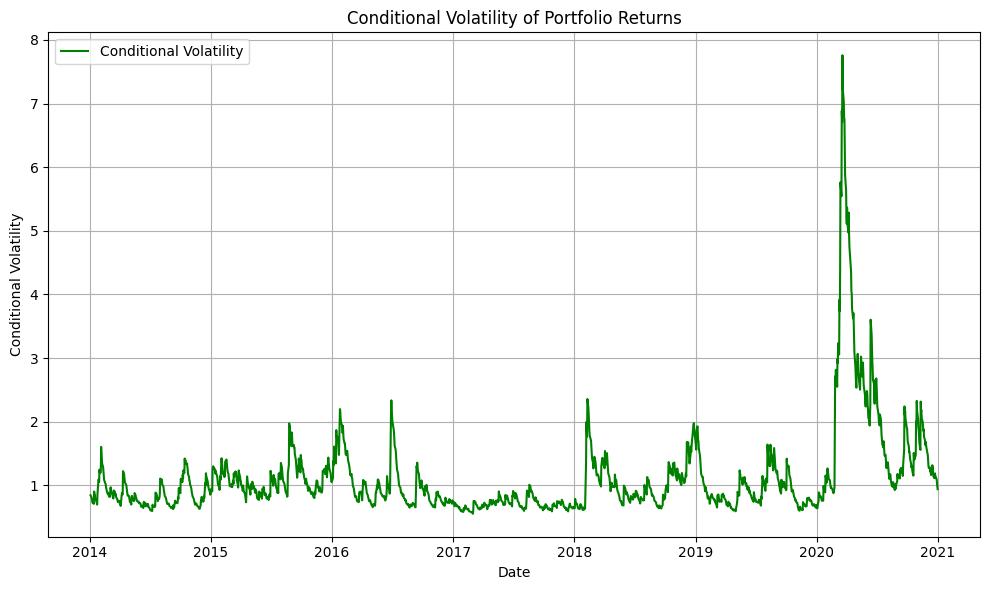

In [ ]:
weights = np.array([1/3, 1/3, 1/3])
H_t = dcc_model.Ht

dcc_conditional_volatility = []
for i in range(len(H_t)):
  var = np.sqrt(weights @ H_t[i] @ weights.T)
  dcc_conditional_volatility.append(var)

plt.figure(figsize=(10, 6))
plt.plot(portfolio['Date'], dcc_conditional_volatility, label='Conditional Volatility', color='green')
plt.title('Conditional Volatility of Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Copula-DCC-GARCH model’s conditional volatility captures stable, low volatility from 2014 to 2019, with occasional mild spikes. In early 2020, there’s a sharp surge in volatility, aligning with the COVID-19 crisis, which the model effectively captures, showing its responsiveness to extreme events and shifting dependencies among assets. Post-2020, volatility remains elevated, indicating persistent market uncertainty. The Copula-DCC approach is valuable here, as it captures not only time-varying correlations but also tail dependencies, making it well-suited for assessing risk in volatile, interconnected markets.

In [ ]:
stock_names = ['AXP', 'PEP', 'MAR']

corr_name_list=[]
for i, name_a in enumerate(stock_names):
    if i == 0:
        pass
    else:
        for name_b in stock_names[:i]:
            corr_name_list.append(name_a + "-" + name_b)
veclRt = Corr_data(dcc_model.epsilon, ab)

In [ ]:
dcc_corr = pd.DataFrame(veclRt, index = portfolio['Date'], columns= corr_name_list)
dcc_plot = px.line(dcc_corr, title = 'Dynamic Conditional Correlation plot', width=1000, height=500, )
dcc_plot.write_html('all_tockens.html')
dcc_plot.show()

The Dynamic Conditional Correlation (DCC) plot shows time-varying correlations among the stocks-pair PEP-AXP, MAR-AXP, and MAR-PEP, as estimated by the Copula-DCC-GARCH model. The correlations fluctuate significantly over time, generally ranging between -0.4 and 0.8, indicating that relationships between these assets are highly dynamic.

Overall, the model captures the dynamic and sometimes asymmetric dependencies, allowing portfolio managers to adjust for shifts in asset relationships, particularly under stress conditions. This adaptability enables better diversification strategies, as it highlights when diversification benefits are lower due to rising correlations. This will be applied in our Portfolio Contruction using Modern Portfolio Theory below.

### 3.2 Backtest the multivariate models using the VaR approach (1 mark)

Number of violations: 82
Expected violations (at 5.0%): 88.10000000000001
P-value (Kupiec's test): 0.5001285088360277


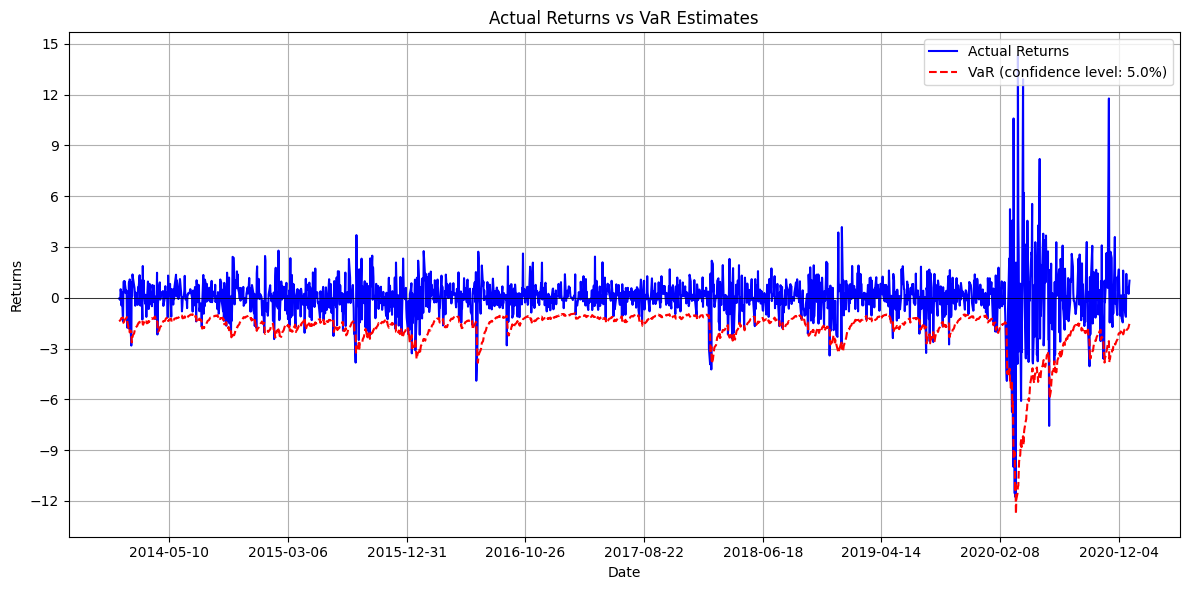

In [ ]:
VaR_test(returns, portfolio['Date'], np.array(dcc_conditional_volatility))

The Value at Risk (VaR) plot using the Copula-DCC-GARCH model shows the estimated 5% VaR (dashed red line) alongside the actual returns (solid blue line):

- The Copula-DCC-GARCH model’s in-sample performance, based on the Kupiec’s test p-value (0.7333), is very good. This p-value is equal to that of the GJR-GARCH(1,1,1) model as they show a similar number of VaR violations. This suggests that both models fit the in-sample data equally well.

- While the in-sample fit is important, the out-of-sample (OS) performance is more critical for assessing the model’s robustness and predictive power.

Now, let's check it out!



## 4. Out-Sample Test - Whether our results are robust?

Up until now, we've only used the In-Sample (IS) data to analyze and fit our model. However, it is crucial to assess the model's performance in the Out-of-Sample (OS) test to determine its predictive accuracy and robustness.








### First, we will test the OS perfomance of GJR-GARCH(1,1,1) model

In [ ]:
# Step 1: Extract the last fitted variance from the in-sample period
gjr_last_vol = gjr_results.conditional_volatility.iloc[-1]
gjr_last_resid = gjr_results.resid.iloc[-1]  # Last in-sample residual

# Step 2: Get model parameters from fitted results (gjr_results)
gjr_omega = gjr_results.params['omega']
gjr_alpha = gjr_results.params['alpha[1]']
gjr_gamma = gjr_results.params['gamma[1]']
gjr_beta = gjr_results.params['beta[1]']

# Step 3: Initialize arrays to store conditional variance and residuals for out-of-sample data
gjr_n_obs_os = len(returns_os)
gjr_conditional_variance_os = np.zeros(gjr_n_obs_os)
gjr_residuals_os = np.zeros(gjr_n_obs_os)

# Step 4: Iteratively calculate conditional variance for out-of-sample returns
for i in range(gjr_n_obs_os):
    # Get the return and the sign of the return for the GJR term
    gjr_r_t = returns_os.iloc[i]
    gjr_negative_r_t = 1 if gjr_last_resid < 0 else 0  # Indicator for negative return

    # Update conditional variance based on the GJR-GARCH(1,1,1) formula
    gjr_conditional_variance_os[i] = (
        gjr_omega
        + gjr_alpha * (gjr_last_resid**2)
        + gjr_gamma * gjr_negative_r_t * (gjr_last_resid**2)
        + gjr_beta * (gjr_last_vol**2)
    )

    # Update residual and volatility for the next step
    gjr_residuals_os[i] = gjr_r_t
    gjr_last_resid = gjr_residuals_os[i]
    gjr_last_vol = np.sqrt(gjr_conditional_variance_os[i])

# Step 5: Compute the conditional volatility (square root of variance)
gjr_conditional_volatility_os = np.sqrt(gjr_conditional_variance_os)

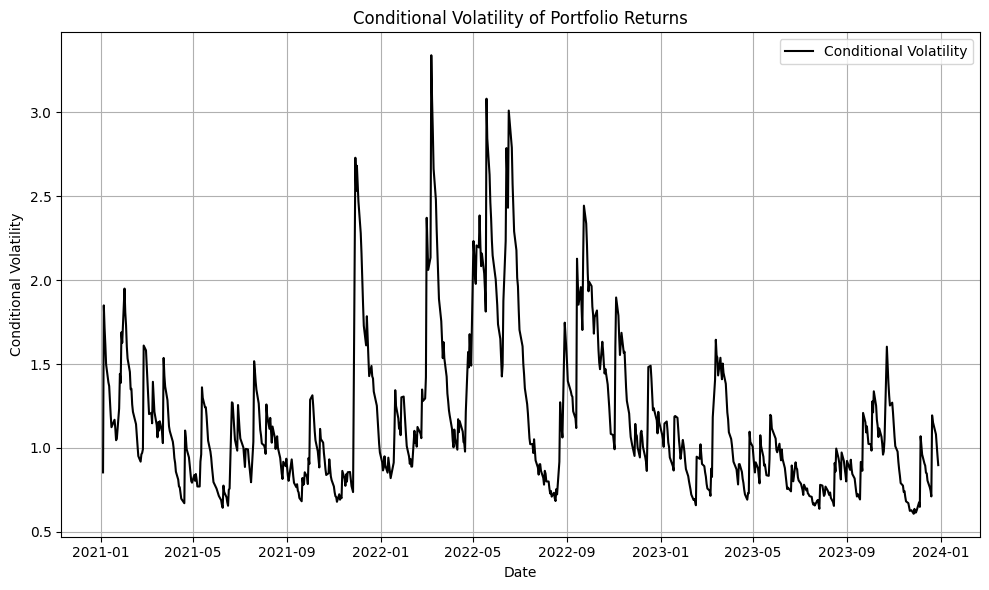

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_os['Date'], gjr_conditional_volatility_os, label='Conditional Volatility', color='black')
plt.title('Conditional Volatility of Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The GJR-GARCH(1,1,1) Out-sample conditional volatility shows notable spikes in early and mid-2022, reflecting periods of high market uncertainty. Volatility reverts to a baseline around 1 after each spike, demonstrating mean-reverting behavior. Elevated levels in 2023 indicate a generally more volatile environment. The model effectively captures volatility clustering and asymmetry in the OS period.

Now, we will assess whether the model remains robust in predicting Value at Risk (VaR) at a 5% confidence level.

Number of violations: 47
Expected violations (at 5.0%): 37.65
P-value (Kupiec's test): 0.13161749080077034


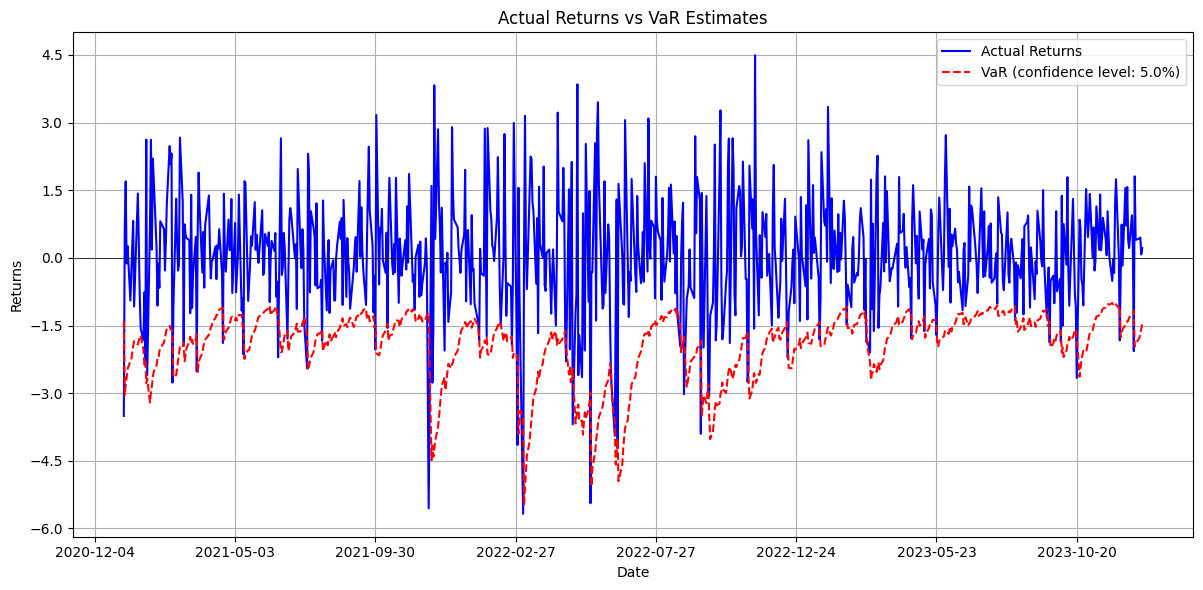

In [ ]:
VaR_test(returns_os, portfolio_os['Date'], gjr_conditional_volatility_os)

The out-of-sample (OS) Value at Risk (VaR) prediction by the GJR-GARCH(1,1,1) model shows limited reliability. Although the model was well-fitted in-sample, the Kupiec’s test p-value of 0.0963 (which means the hypothesis could be rejected at 10% level of significant) indicates quite poor OS performance, meaning the actual violations (48) significantly deviate from the expected 5% threshold (37.65). This suggests that the model underestimates risk in the OS period, failing to capture the actual frequency of extreme returns accurately.

Now, let's evaluate the Copula-DCC-GARCH model, which might better capture the changing correlations and tail dependencies needed for robust OS VaR predictions

### Second, we will test the OS perfomance of Copula-DCC-GARCH model

In [ ]:
weights = np.array([1/3, 1/3, 1/3])
H_t_os = dcc_model.Ht_forecast(portfolio_os[['AXP_rt', 'PEP_rt', 'MAR_rt']].copy())
dcc_conditional_volatility_os = []

for i in range(len(H_t_os)):
  var = np.sqrt(weights @ H_t_os[i] @ weights.T)
  dcc_conditional_volatility_os.append(var)

dcc_conditional_volatility_os = np.array(dcc_conditional_volatility_os)

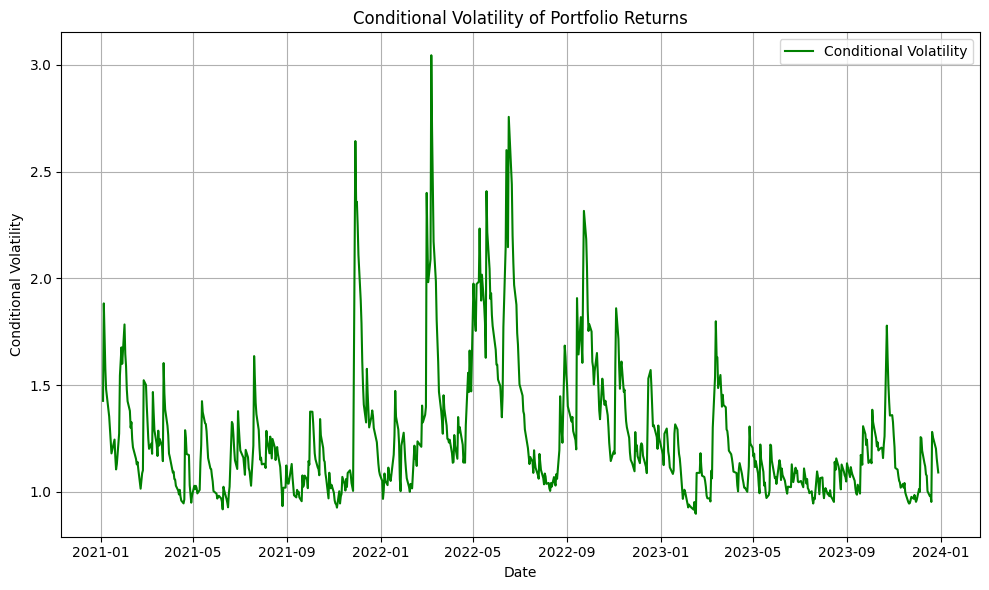

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_os['Date'], dcc_conditional_volatility_os, label='Conditional Volatility', color='green')
plt.title('Conditional Volatility of Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The Copula-DCC-GARCH model captures OS conditional volatility effectively, showing clear spikes in mid-2022 during high market uncertainty and adapting smoothly to fluctuations. Post-2022, volatility stabilizes but remains responsive to minor shifts, indicating robust adaptability to changing market conditions.

Number of violations: 33
Expected violations (at 5.0%): 37.65
P-value (Kupiec's test): 0.42747078706602526


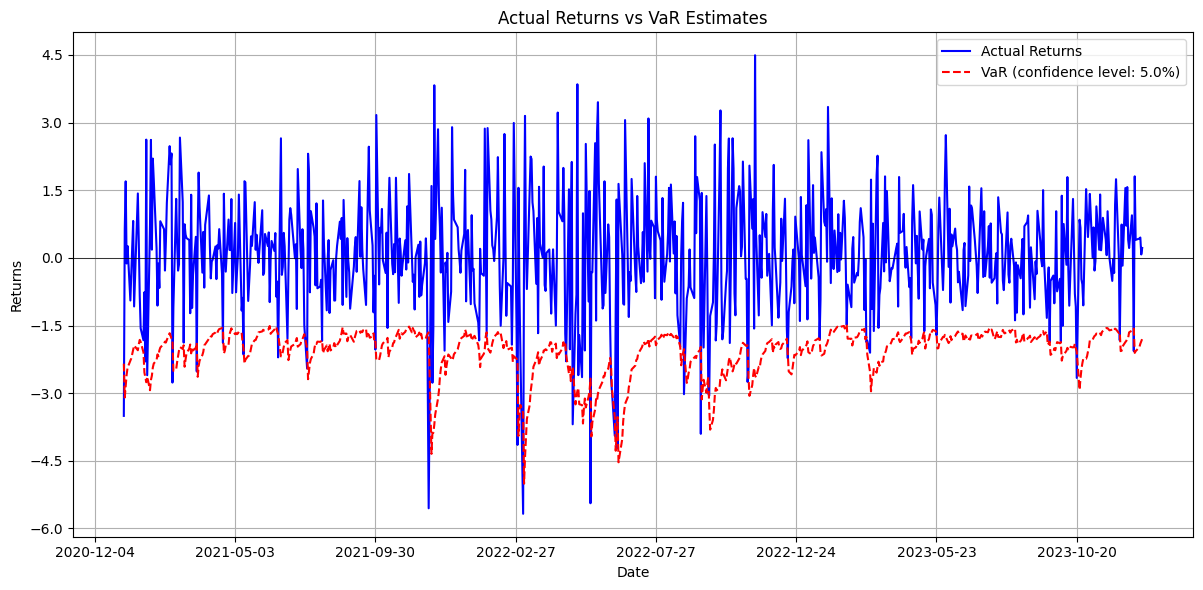

In [ ]:
VaR_test(returns_os, portfolio_os['Date'], dcc_conditional_volatility_os)

Easy to see, the Copula-DCC-GARCH model shows superior out-of-sample (OS) performance in Value at Risk (VaR) prediction compared to the GJR-GARCH(1,1,1) model. With 32 actual violations versus an expected 37.65 at the 5% level, the Kupiec’s test p-value of 0.33 indicates a good fit, reflecting fewer deviations from expected VaR breaches and greater accuracy in capturing extreme returns. This superior performance highlights the Copula-DCC-GARCH model's effectiveness in adjusting to time-varying correlations and tail dependencies, providing a more robust risk measure in OS conditions.

## 5. Modern Portfolio Theory leveraged by Copula-DCC-GARCH


In the paper: "***Improved Dynamic Portfolio Selection Model with DCC-GARCH: Evidence from the U.S. Stock***" of **Siyu Wang et. al (2022)**, they have proved that  portfolio returns obtained by the dynamic model outperform the original static portfolio and market performance by a large margin. This shows that, without taking into account transaction costs, an effective way to enhance the
traditional mean-variance model is to fit and predict the dynamic covariance using DCC-GARCH model.

Now, I will apply the Copula-DCC-GARCH model within the framework of Modern Portfolio Theory to enhance my portfolio results. By using DCC, I aim to capture the changing correlations between assets over time, allowing for a more adaptive and optimized portfolio that better manages risk and potentially improves returns in response to market dynamics.

In [ ]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_volatility

def neg_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0):
    p_return, p_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_volatility

# Contraint for optimization
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = tuple((0, 1) for _ in range(3))
initial_guess = [1/3, 1/3, 1/3]

Here, I set the fixed expected returns for each stocks as their In-Sample Returns mean.

In [ ]:
mean_returns = np.array(portfolio[['AXP_rt', 'PEP_rt', 'MAR_rt']].mean())

### 5.1 First approach: Fixed portfolio weights are determined using Modern Portfolio Theory based on fixed expected returns and a fixed covariance matrix.

This static approach assigns weights that optimize the risk-return trade-off under the assumption that both returns and covariances remain constant over time.

In [ ]:
cov_matrix_fixed = np.array(portfolio[['AXP_rt', 'PEP_rt', 'MAR_rt']].cov())
optimal_portfolio_fix = minimize(neg_sharpe, initial_guess, args=(mean_returns, cov_matrix_fixed), method='SLSQP', bounds=bounds, constraints=constraints)
weight_fix = optimal_portfolio_fix.x #--> Optimal weight

In [ ]:
portfolio_returns_fix = np.dot(np.array(portfolio[['AXP_rt', 'PEP_rt', 'MAR_rt']]),weight_fix.T )
portfolio_returns_fix_os = np.dot(np.array(portfolio_os[['AXP_rt', 'PEP_rt', 'MAR_rt']]),weight_fix.T )

From the calculated returns after assignning the fixed optimal weights to the portfolio, we calculate the PnL

In [ ]:
# Step 1: Calculate cumulative returns
fixed_weight_cumulative_returns = (1+portfolio_returns_fix/100).cumprod()

# Step 2: Convert cumulative returns to PnL
initial_investment = 10000
fixed_weight_pnl = initial_investment * fixed_weight_cumulative_returns

In [ ]:
# Step 1: Calculate cumulative returns
fixed_weight_cumulative_returns_os = (1+portfolio_returns_fix_os/100).cumprod()

# Step 2: Convert cumulative returns to PnL
initial_investment = 10000
fixed_weight_pnl_os = initial_investment * fixed_weight_cumulative_returns_os

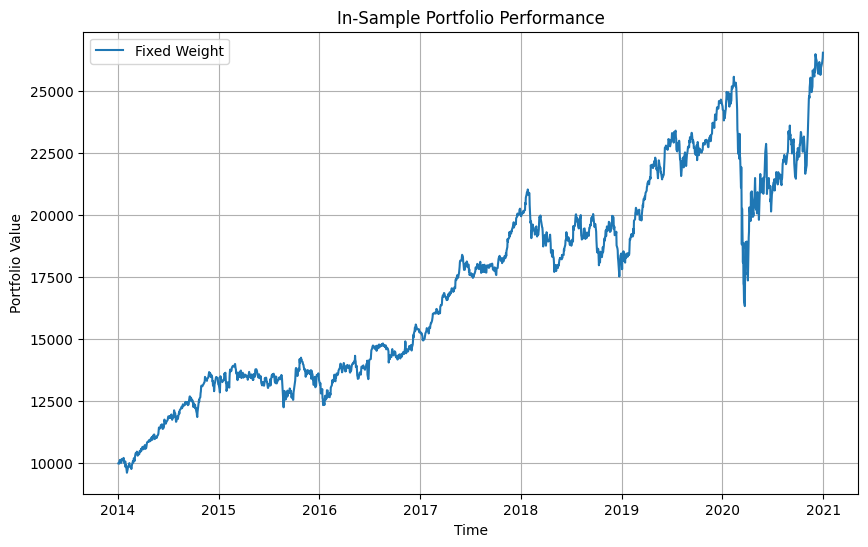

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(portfolio['Date'], fixed_weight_pnl, label='Fixed Weight')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('In-Sample Portfolio Performance')
plt.legend()
plt.grid(True)
plt.show()

The portfolio shows steady growth from 2014 to 2020, nearly doubling in value under a fixed-weight strategy. It experiences a sharp drop during the early 2020 COVID-19 crash but quickly rebounds to new highs, demonstrating resilience. Overall, the strategy balances growth and risk well, capturing market uptrends while withstanding major downturns effectively.

### 5.2 Second approach: Dynamic portfolio weights determined using Modern Portfolio Theory based on fixed expected returns and a dynamic covariance matrix estimated by Copula-DCC-GARCH model

This approach allows the portfolio to adjust asset weights in response to time-varying correlations and volatilities, enhancing risk management and adaptability in changing market conditions.

In [ ]:
# Finding weights for the portfolio given changing Covariance Matrix each day
weight_change = []
for cov in H_t:
    optimal_portfolio = minimize(neg_sharpe, initial_guess, args=(mean_returns, cov), method='SLSQP', bounds=bounds, constraints=constraints)
    weight_change.append(optimal_portfolio.x)

weight_change_os = []
for cov in H_t_os:
    optimal_portfolio = minimize(neg_sharpe, initial_guess, args=(mean_returns, cov), method='SLSQP', bounds=bounds, constraints=constraints)
    weight_change_os.append(optimal_portfolio.x)

Once the dynamic weights are obtained, we compute the portfolio returns and the conditional volatility

In [ ]:
# Portfolio Returns
dcc_portfolio_returns = (np.array(portfolio[['AXP_rt', 'PEP_rt', 'MAR_rt']].copy()) * np.array(weight_change)).sum(axis=1)
dcc_portfolio_returns_os = (np.array(portfolio_os[['AXP_rt', 'PEP_rt', 'MAR_rt']].copy()) * np.array(weight_change_os)).sum(axis=1)

First is the In-Sample Conditional Volatility

In [ ]:
# Portfolio Conditional Volatility
H_t = dcc_model.Ht

active_dcc_conditional_volatility = []
for i in range(len(H_t)):
  var = np.sqrt(weight_change[i] @ H_t[i] @ weight_change[i].T)
  active_dcc_conditional_volatility.append(var)

active_dcc_conditional_volatility = np.array(active_dcc_conditional_volatility)

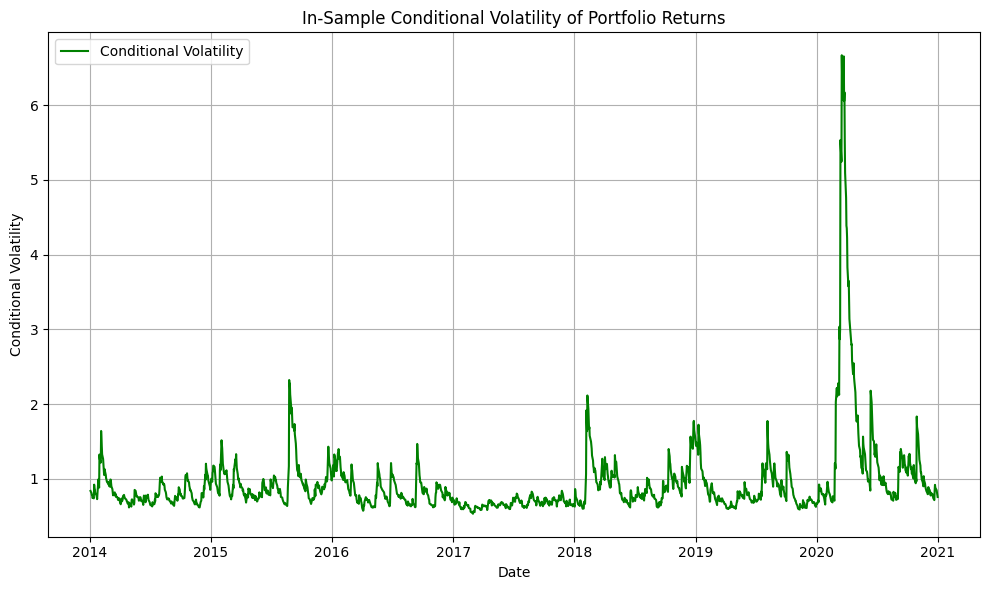

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio['Date'], active_dcc_conditional_volatility, label='Conditional Volatility', color='green')
plt.title('In-Sample Conditional Volatility of Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

we will perform the In Sample VaR test on this In-Sample portfolio returns.

Number of violations: 89
Expected violations (at 5.0%): 88.10000000000001
P-value (Kupiec's test): 0.9217585440077332


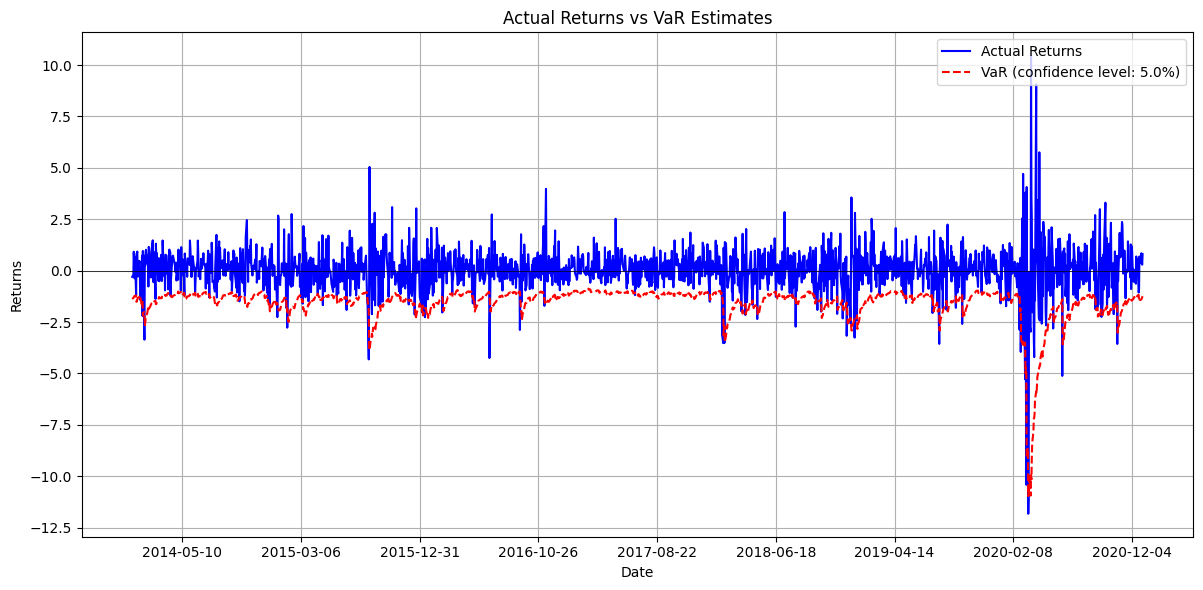

In [ ]:
VaR_test(dcc_portfolio_returns, portfolio['Date'], active_dcc_conditional_volatility)

The plot shows a well-fitted model with number of actual violation approximately equal to expected one, indicating that the VaR line accurately capturing downside risk. During the 2020 market crash, returns fall sharply below VaR, as expected in extreme events. Overall, the model effectively estimates risk in typical markets.

Next, we compute the Out-Sample Conditional Volatility

In [ ]:
H_t_os = dcc_model.Ht_forecast(portfolio_os[['AXP_rt', 'PEP_rt', 'MAR_rt']].copy())
active_dcc_conditional_volatility_os = []

for i in range(len(H_t_os)):
  var = np.sqrt(weight_change_os[i] @ H_t_os[i] @ weight_change_os[i].T)
  active_dcc_conditional_volatility_os.append(var)

active_dcc_conditional_volatility_os = np.array(active_dcc_conditional_volatility_os)

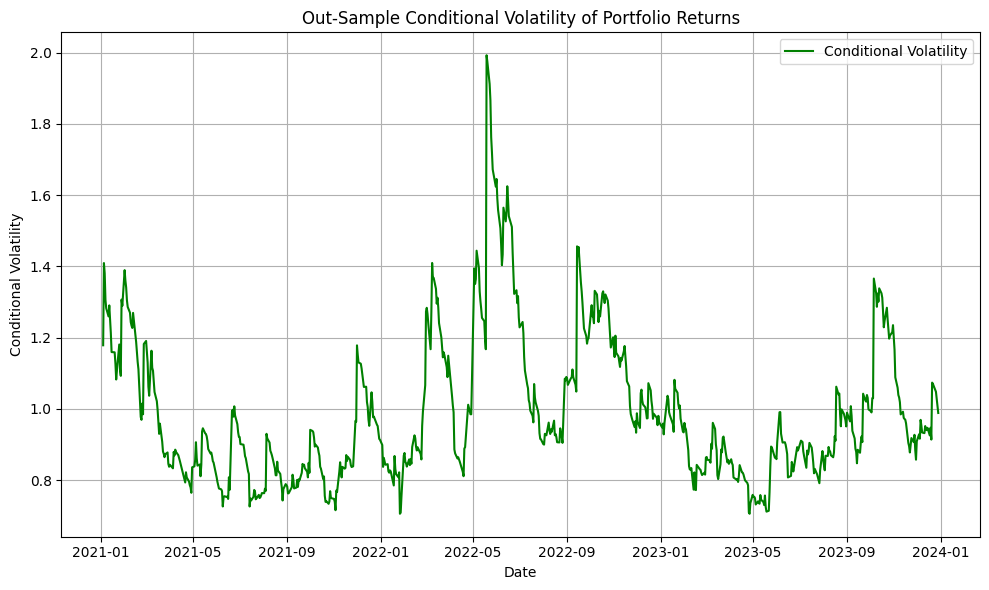

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_os['Date'], active_dcc_conditional_volatility_os, label='Conditional Volatility', color='green')
plt.title('Out-Sample Conditional Volatility of Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Number of violations: 34
Expected violations (at 5.0%): 37.65
P-value (Kupiec's test): 0.5352222472504111


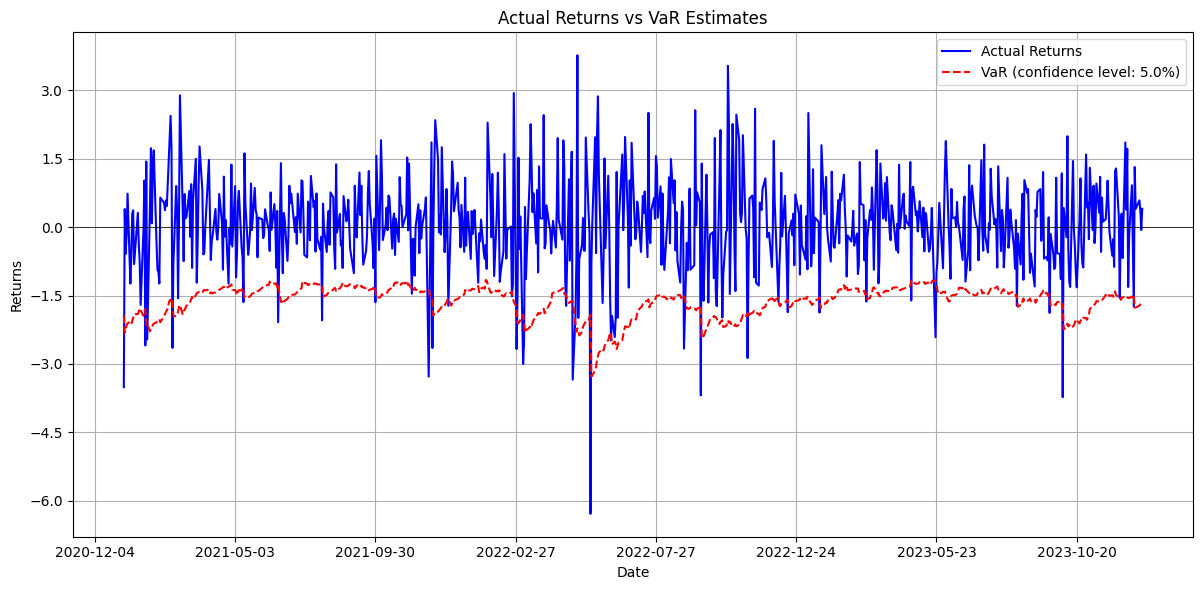

In [ ]:
VaR_test(dcc_portfolio_returns_os, portfolio_os['Date'], active_dcc_conditional_volatility_os)

The model maintains excellent performance, with actual violations aligning closely with the expected 5% level. The VaR boundary accurately captures the downside risk.

In [ ]:
# Step 1: Calculate cumulative returns
dcc_weight_cumulative_returns = (1+dcc_portfolio_returns/100).cumprod()

# Step 2: Convert cumulative returns to PnL
initial_investment = 10000
dcc_weight_pnl = initial_investment * dcc_weight_cumulative_returns

In [ ]:
# Step 1: Calculate cumulative returns
dcc_weight_cumulative_returns_os = (1+dcc_portfolio_returns_os/100).cumprod()

# Step 2: Convert cumulative returns to PnL
initial_investment = 10000
dcc_weight_pnl_os = initial_investment * dcc_weight_cumulative_returns_os

### 5.3 Comparing 2 approachs: Fixed portfolio weights vs Dynamic portfolio weights

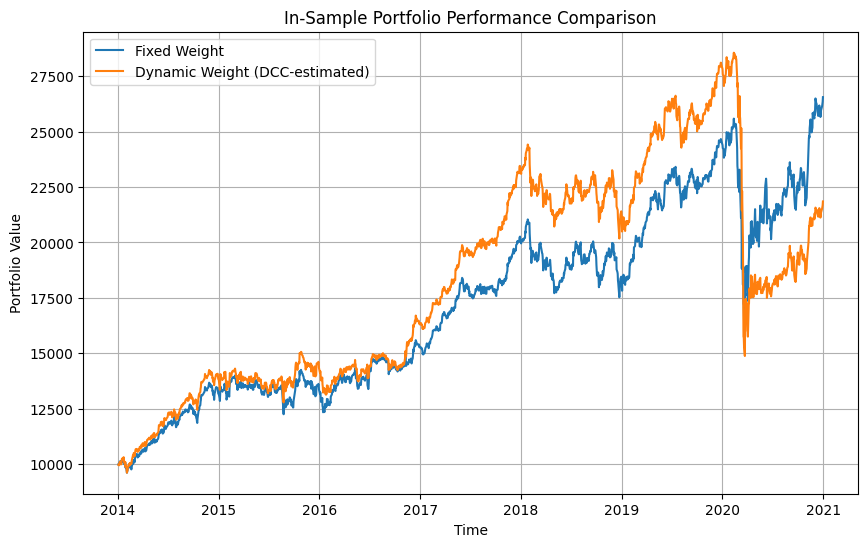

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(portfolio['Date'], fixed_weight_pnl, label='Fixed Weight')
plt.plot(portfolio['Date'], dcc_weight_pnl, label='Dynamic Weight (DCC-estimated)')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('In-Sample Portfolio Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

Contrary to expectations, the Dynamic Weight portfolio does not outperform the Fixed Weight portfolio.

The Dynamic Weight (DCC-estimated) strategy initially outperformed the Fixed Weight strategy, maintaining higher portfolio values until 2020. However, the high volatility during the 2020 market crash likely reduced the accuracy of the covariance matrix predictions, leading to greater drawdowns.

Following this period, the Dynamic Weight strategy failed to recover, while the Fixed Weight approach remained more stable and ultimately matched or surpassed the Dynamic Weight portfolio by the end of the period.


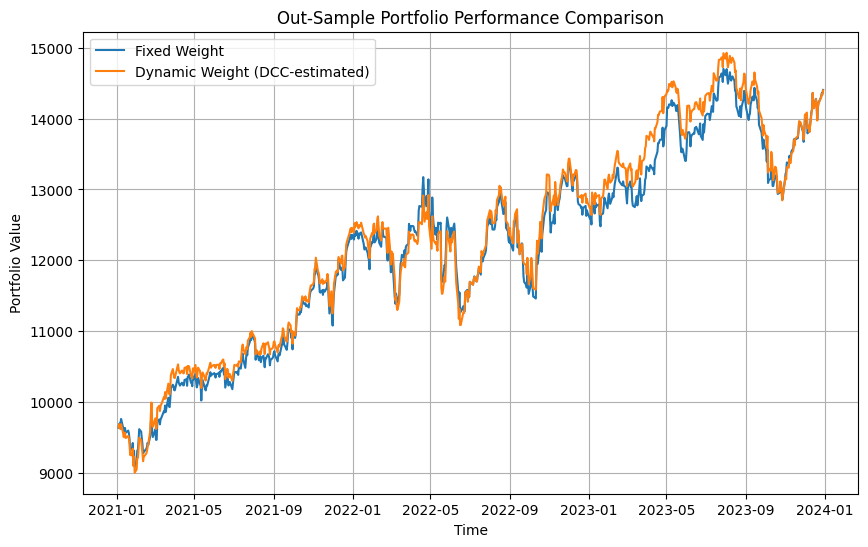

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(portfolio_os['Date'], fixed_weight_pnl_os, label='Fixed Weight')
plt.plot(portfolio_os['Date'], dcc_weight_pnl_os, label='Dynamic Weight (DCC-estimated)')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Out-Sample Portfolio Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

In the out-of-sample period, the Dynamic Weight (DCC-estimated) strategy continues to underperform relative to the Fixed Weight strategy.

In [ ]:
def decay_linear(weights, n):

    decay_factors = np.arange(1,n+1)

    # Initialize an empty list to store smoothed weights
    decayed_weights = []

    for i in range(len(weights)):
        # Determine the start and end of the current window
        start = max(0, i - n + 1)
        end = i + 1

        # Get the current window of weights
        window = weights[start:end]

        # Adjust decay factors for shorter windows at the start of the series
        current_factors = np.array(decay_factors[:len(window)])
        current_sum = np.sum(current_factors)

        # Calculate the decayed weight
        decayed_value = current_factors @ np.array(window) / current_sum
        decayed_weights.append(decayed_value)

    return np.array(decayed_weights)

In [ ]:
weight_change_decay = decay_linear(weight_change, 150)
weight_change_decay_os = decay_linear(weight_change_os, 150)